# Impact of essential workers in the context of social distancing for epidemic control
The following notebook contains all code and scripts necessary to reproduce the results and figures from the main paper. In addition, there are explanations of the methods and supplementary figures to support the main text. Cells should be run sequentially.

In [22]:
# Libraries
# The code was initially inspired by the following sources:
# https://www.kaggle.com/pstarszyk/seir-model-with-extensions/comments#Define-Extended-Model
# https://www.kaggle.com/anjum48/seir-hcd-model/data#SEIR-HCD-Model
# http://gabgoh.github.io/COVID/index.html
# https://neherlab.org/covid19/about

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from collections import namedtuple
from collections import defaultdict as ddict
from copy import deepcopy
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pylab as plt
from seaborn import heatmap
from pyDOE import *

In [23]:
# This is a function used to control the font size in generating the figures
def update_font_size(font_size = 30,rcParams = mpl.rcParams):
    rcParams.update({'font.size': font_size})
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size*1.1)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size) 

We consider three separate SEIR models of essential workers: public-facing, non-public-facing, and healthcare workers. For simplicity, in the code these are referred to as 'Cashier', 'USPS', and 'Healthcare' models, respectively. Moreover, the 'No Structure' model refers to a model where there are no essential workers. This code block defines the names of these models.

In [24]:
# Make model labels a global so we can access anywhere
model_labels = {'Cashier'         :'Public Facing',
                'USPS'        :'Non-Public Facing',
                'Healthcare'  :'Healthcare',
                'No Structure':'No EWs',
                'Healthcare_Sigmoid'  :'Healthcare'}

The following code block contains the differential equations used in our compartmentalized SEIR model. We model the dynamics of the epidemic by considering different classes (shown below) and these equations describe the rate of movement between classes as a function of time. Following recent work, we expand on a standard SEIR epidemological framework, by including additional comaprtments for infectious individuals and a hospitalized class that contains additional compartments for individuals requiring critical care.
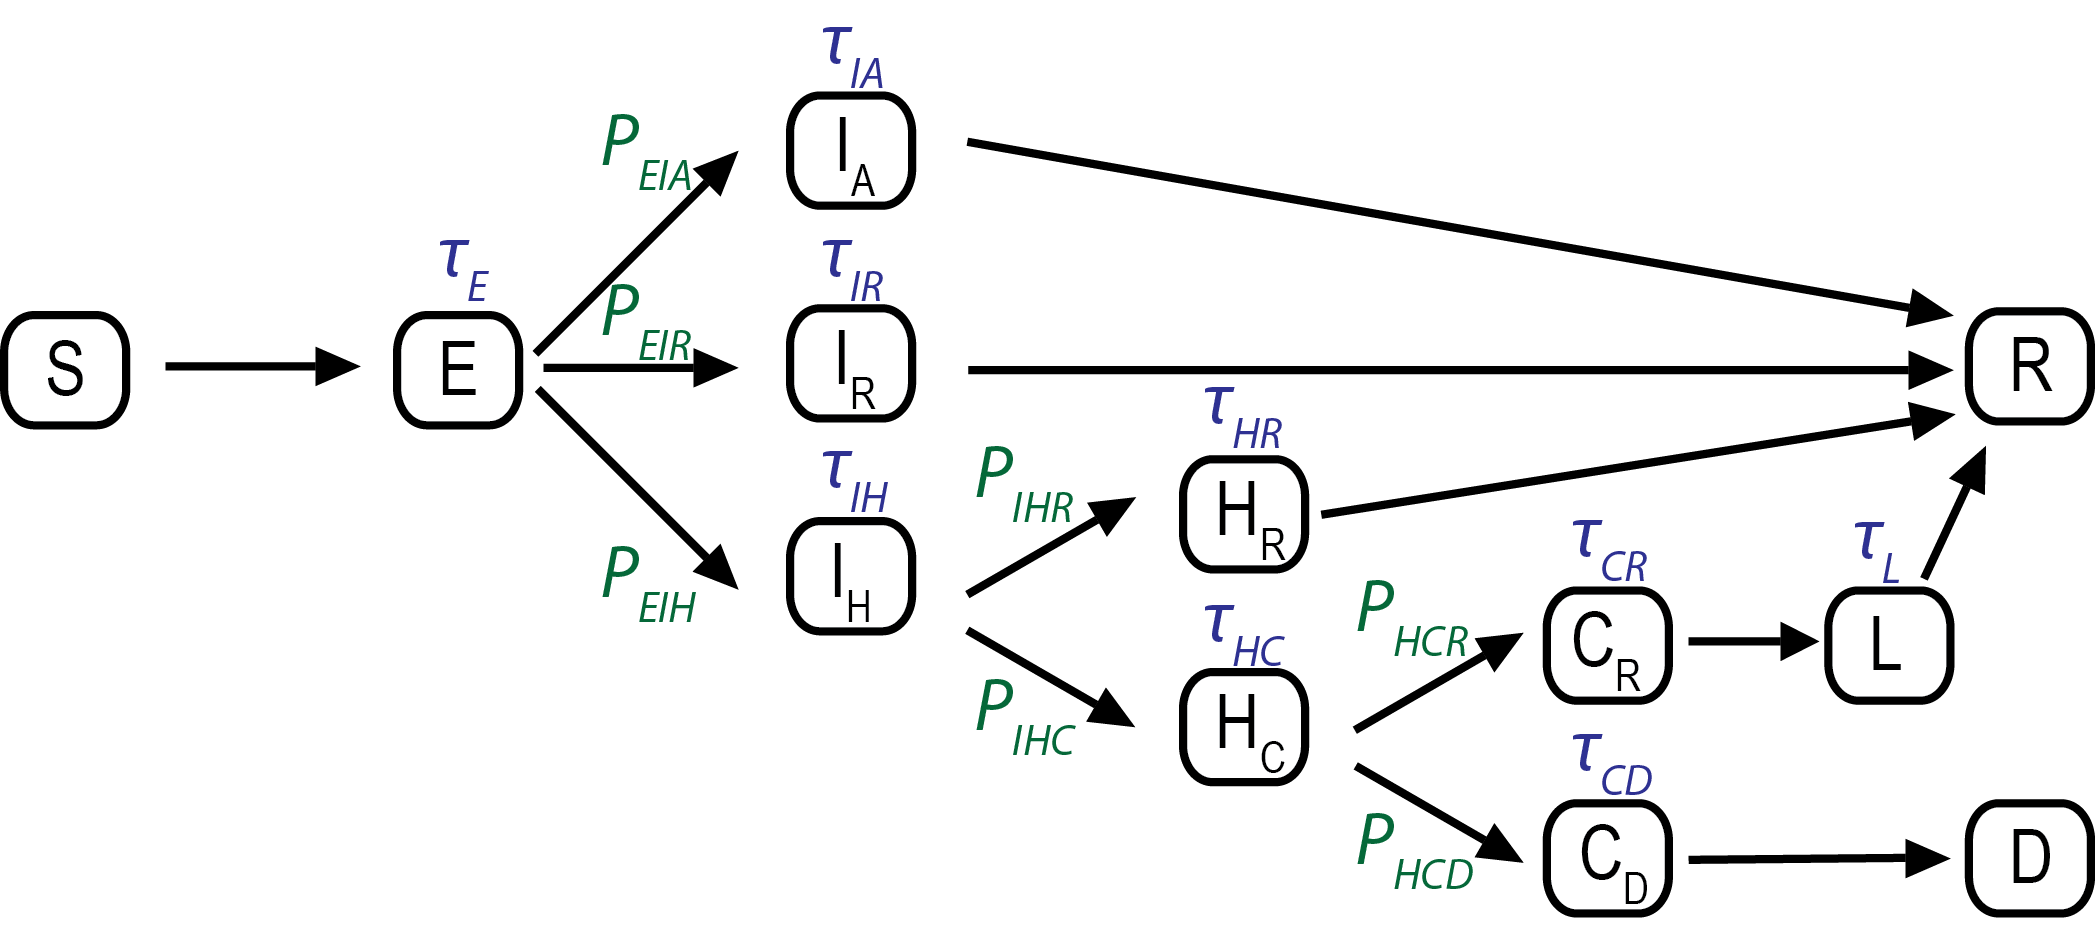
Here, ‘$S$’ is susceptible, ‘$E$’ is exposed, ‘$I$’ is infected, ‘$H$’ is hospitalized, ‘$D$’ is dead, and ‘$R$’ is recovered. Within the infected class, individuals can be asymptomatic ‘$I_A$’ and destined to recover; symptomatic ‘$I_R$’ but destined to recover; or symptomatic ‘$I_H$’ and destined to be hospitalized. Within the hospital, individuals either go to recovery ‘$H_R$’ or go to critical care ‘$H_C$’. For those in critical care, individuals either die ‘$C_D$’ or go on to the recovered class ‘$C_R$’, with an additional time spent in the hospital ‘$L$’. Above each compartment in blue are time parameters $\tau$ that describe how long individuals spend in each. Above arrows in red are parameters $P$ that describe the probability an individual moves to a different class. 

In [25]:
# Susceptible equation
def dS_dt(y_i, p, N_i, I, Beta_t, H, Beta_hosp, groupID):
    if groupID == 1 and p.model == 'Healthcare_Sigmoid':
        return - y_i.S * (sum(Beta_t * I) * (1./N_i) + Beta_hosp)
    else:
        return -(1./N_i) * y_i.S * ( sum(Beta_t * I) + Beta_hosp * H)
   
# Exposed equation
def dE_dt(y_i, p, N_i, I, Beta_t, H, Beta_hosp, groupID):
    if groupID == 1 and p.model == 'Healthcare_Sigmoid':
        incoming = y_i.S * (sum(Beta_t * I) * (1./N_i) + Beta_hosp)
    else:
        incoming = (1./N_i) * y_i.S * ( sum(Beta_t * I) + Beta_hosp * H )
    return incoming - (y_i.E / p.t_inc)
   
# Infected, asymptomatic, and will recover equation
def dIA_dt(y_i, p,groupID):
    if groupID == 1:
        p_IA = p.p_IA * p.change_in_p_IA
    else:
        p_IA = p.p_IA
    return (y_i.E / p.t_inc) * p_IA - y_i.IA / p.t_AR

# Infected, symptomatic, and will recover equation
def dIR_dt(y_i, p,groupID):
    if groupID == 1:
        p_IA = p.p_IA * p.change_in_p_IA
        p_IH = p.p_IH * p.change_in_p_IH
    else:
        p_IA = p.p_IA
        p_IH = p.p_IH
    return (y_i.E / p.t_inc)*(1-p_IA)*(1-p_IH) - y_i.IR / p.t_IR

# Infected and will require hospitalization equation
def dIH_dt(y_i, p,groupID):
    if groupID == 1:
        p_IA = p.p_IA*p.change_in_p_IA
        p_IH = p.p_IH*p.change_in_p_IH
    else:
        p_IA = p.p_IA
        p_IH = p.p_IH
    return (y_i.E / p.t_inc)*(1-p_IA)*p_IH  - y_i.IH / p.t_IH

# Recovered equation
def dR_dt(y_i, p,groupID):
    return  y_i.IR / p.t_IR + y_i.IA / p.t_AR + y_i.HR / p.t_HR + y_i.L / p.t_LR

# Hospitalized and will recover equation
def dHR_dt(y_i, p,groupID):
    return  y_i.IH / p.t_IH * (1 - p.p_HC) - y_i.HR / p.t_HR

# Hospitalized and will require critical care equation
def dHC_dt(y_i, p,groupID):
    return  y_i.IH / p.t_IH * p.p_HC - y_i.HC / p.t_HC

# Critical care and will recover equation
def dCR_dt(y_i, p,groupID):
    return  y_i.HC / p.t_HC * (1 - p.p_CD) - (y_i.CR / p.t_CL)

# Critical and will die equation
def dCD_dt(y_i, p, groupID):
    return y_i.HC / p.t_HC * p.p_CD - y_i.CD / p.t_CD

# Post-Critical care but still hospitalized equation
def dL_dt(y_i, p,groupID):
    return y_i.CR / p.t_CL - y_i.L / p.t_LR

# Dead equation
def dD_dt(y_i, p,groupID):
    return y_i.CD / p.t_CD

In [26]:
# Parameters: Using a namedtuple allows you to access parameters by name instead of index (e.g. args.N)
parameters = namedtuple('parameters',["R_0","N","C",
                                      "social_distancing_time","theta","model","proportion_essential","rho",
                                      "max_days","num_groups","compartment_names",
                                      "t_inc","t_AR","t_IR","t_IH","t_HR","t_HC","t_CD","t_CL","t_LR",
                                      "p_IA","p_IH","p_HC","p_CD",
                                      "change_in_p_IH","change_in_p_IA","adjust_beta_hosp"])

# Define the compartments and link names with formulas
compartment_names = ["S","E","IA","IR","IH","HR","HC","CR","CD","L","R","D"]
compartment_formulas = [dS_dt,dE_dt,dIA_dt,dIR_dt,dIH_dt,dHR_dt,dHC_dt,dCR_dt,dCD_dt,dL_dt,dR_dt,dD_dt]
compartments = namedtuple("compartments",compartment_names)

In [27]:
# This function returns an array of differential equations that is used for the ODE solver in the following section
def SEIR_HCD_model(t, y_vals, parameters):
    
    # Convert to matrix
    # Each row is a group
    # Each column corresponds to a given class within each group
    # Columns indexed according to position in name array: compartment_names = ["S", "E", "I", "R", "H", "C", "D"]
    y_matrix = np.reshape(y_vals,[parameters.num_groups,len(compartment_names)])

    output = np.zeros(np.shape(y_matrix))
    
    # Iterate over each group
    # Nonessential = 0
    # Essential = 1

    for group_idx in range(parameters.num_groups):
        
        Beta_t_i = get_betas(t,parameters,group_idx)
    
        # Components for group i
        compartments_group_i = compartments(*y_matrix[group_idx,:])
        
        # Total population within group i
        N_i = sum(y_matrix[group_idx,:])
        
        # Get the infected population for each group for all 3 compartments
        I = sum(np.transpose(y_matrix[:,2:5]))
        
        # Get the hospitalized population for each group
        H = sum(sum(np.transpose(y_matrix[:,5:10])))
        
        # If using a healthcare model and considering the healthcare group, 
        # we need to consider infections stemming from hospitals
        if 'Healthcare' in parameters.model and group_idx == 1:
            
            # Determine the beta or fraction of workers infected
            beta_hosp = get_hosp_beta(t,parameters,H)
        
        else:
            
            beta_hosp = 0
            
        # Susceptibles and Exposed DiffEq use special parameters I and Beta_t_i)
        S_out_i = dS_dt(y_i = compartments_group_i, 
                        p   = parameters, 
                        N_i = N_i, 
                        I   = I, 
                        Beta_t = Beta_t_i, 
                        H   = H, 
                        Beta_hosp = beta_hosp, 
                        groupID = group_idx)
        
        output[group_idx,0] = S_out_i
        
        E_out_i = dE_dt(compartments_group_i, parameters, N_i, I, Beta_t_i, H, beta_hosp, group_idx)
        output[group_idx,1] = E_out_i
        
        # The remainder of the differentiail equations
        for index in np.arange(2,len(compartment_names)):
            output[group_idx,index] = compartment_formulas[index](compartments_group_i, parameters,group_idx)
        
    # Convert the matrix back into a linear array for the ODE solver
    output_array = np.reshape(output,[1,parameters.num_groups*len(compartment_names)])[0]

    return output_array

In the model, we use $\beta$ to represent the number of contacts an individual has per day. Social distancing and other shelter in place (SIP) measures reduce $\beta$ by a parameter by $\theta$. We define $\theta$ as the remaining proportion of individual to individual transmission after social distancing, where $\theta = 1$ corresponds to no social distancing and $\theta = 0$ is complete isolation. In the various models of essential workers we consider, $\theta$ is applied to different $\beta$'s to reduce interactions according to how they are defined in the main text. These functions are used to get the $\beta$ terms under the specified model.

In [28]:
# Return the matrix of thetas that determine how to adjust betas given lockdown
def get_effect_of_social_distancing(p,t=0):
    if p.model == 'No Structure' or (p.rho > 0 and (p.model == 'USPS' or p.model == 'Healthcare' or p.model == 'Healthcare_Sigmoid')):
        social_distancing_effect = np.array([p.theta]*4)
        
    elif p.model == 'Cashier':
        social_distancing_effect = np.array([p.theta]+[1]*3)
        
    elif p.model == 'USPS' or p.model == 'Healthcare' or p.model == 'Healthcare_Sigmoid':

        social_distancing_effect = np.array([p.theta]*3 + [1])
        
    else:
        raise ValueError('Model should be either Cashier,USPS,or No Structure. ' 
                         + p.model + ' is not an implemented model')
        
    social_distancing_effect = np.reshape(social_distancing_effect,[p.num_groups,p.num_groups])
    
    return social_distancing_effect

# Return the beta for within hospital interactions
def get_hosp_beta(t,p,H):
    if p.model == 'Healthcare_Sigmoid':
        return get_sigmoid_beta(t,p,H)
    else: 
        # Default: assume the within beta hospital interaction is the same as the beta between I compartments and S
        return get_infectious_beta(p)*p.adjust_beta_hosp
    
def get_sigmoid_beta(t,p,H):
    
    exponent_parameter = 1
    halfway_point      = 1/4
    max_infection_rate = get_infectious_beta(p)*p.adjust_beta_hosp*1.5*H_max/p.N
    
    halfway_exponent    = halfway_point**exponent_parameter
    h_exponent = (H/H_max)**exponent_parameter
    return ( max_infection_rate * ( h_exponent ) / ( h_exponent+halfway_exponent ) )

def get_infectious_beta(p,model = ''):
    
    # llow user to set model, but otherwise use parameter model
    if not model:
        model = p.model
        
    # Fraction of essential workers
    f     = p.proportion_essential
    
    # Average time spent in I compartments
    avg_time_infectious = (p.p_IA * p.t_AR + (1 - p.p_IA) * ((1-p.p_IH) * p.t_IR + p.p_IH * p.t_IH))
    
    # Average time spent in the hospital
    if model == 'Healthcare':
        avg_time_critical = (1 - p.p_CD) * (p.t_CL + p.t_LR) + p.p_CD * (p.t_CD)
        avg_time_hospital = (1-p.p_HC) * p.t_HR + p.p_HC * (p.t_HC +avg_time_critical)
        avg_time_healthcare = (1 - p.p_IA) * p.p_IH * avg_time_hospital
    else:
        # ignore if not a healthcare model
        avg_time_healthcare = 0
 
    # Get the mixing matrix or set to proportional mixing if not provided
    C = p.C
    if C == []:
        C = np.array([[1-f,1-f],[f,f]])
        
    # Vector to describe the distribution of people
    people_array = np.array([1-f,f])
    
    # The weighted sum across mixings
    beta_coefficient = avg_time_infectious*(sum(np.matmul(C,people_array)) + p.rho * f)
    
    hosp_coefficient   = avg_time_healthcare
    beta = p.R_0/(beta_coefficient + hosp_coefficient * p.adjust_beta_hosp * keep_R0_constant)
    
    return beta

# This allows for greater within-group mixing than under proportional mixing
def get_extra_rho_effect(t,p,groupID):
    if groupID != 1:
        return 0
    
    if t > p.social_distancing_time and p.model == 'No Structure':
            return p.rho * (p.theta)
    return p.rho 
    
def get_betas(t,p,groupID,model = ''):
    
    if not model:
        model = p.model
    social_distancing_effect = get_effect_of_social_distancing(p,t)
    if t>p.social_distancing_time:
        social_distancing_effect = social_distancing_effect[:,groupID]
    else:
        social_distancing_effect = social_distancing_effect[:,groupID] * 0 + 1

    # beta is R_0 * mean infectious time
    # This is the same beta across all infectious compartments and groups
    nointervention_beta = get_infectious_beta(p,model)
    
    # This gives you the betas including the mixing between groups (specific to group i)
    betas = list(nointervention_beta*social_distancing_effect*p.C[groupID,:])
    
    extra_rho = get_extra_rho_effect(t,p,groupID)
    betas[1] += extra_rho * nointervention_beta

    return betas

The parameters we use for the model come from estimates reported in Table 1. 

|Parameter|Variable Name|Value|
|---------|-------------|-----|
|$\tau_E$|t_inc|4.6|
|$\tau_{IA}$|t_AR|5|
|$\tau_{IR}$|t_IR|5|
|$\tau_{IH}$|t_IH|5|
|$\tau_{HR}$|t_HR|8|
|$\tau_{HC}$|t_HC|6|
|$\tau_{CR}$|t_CL|7|
|$\tau_{L}$|t_LR|3|
|$\tau_{CD}$|t_CD|10|
|$P_{EIA}$|p_IA|1/3|
|$P_{EIH}$|p_IH|0.044|
|$P_{IHC}$|p_HC|0.3|
|$P_{CD}$|p_CD|0.5|

Note that $P_{EIH}$ is listed as 0.044 in the table above, but 0.066 in the parameters below. This is because in the code, this value is conditional on not being asymptomatic.

In [29]:
#These are the parameters used in the models. These are listed in Table 1 of the main text.
#By default, R0 is 2.5, however this is changed to 3.2 for most of the subsequent plots
keep_R0_constant = False
args_default = parameters(R_0 = 2.5,                             # R_0: used to calculate betas
                          N   = 8e6,                                 # total population size
                          C   = [],                                 # Mixing matrix

                          social_distancing_time = 50,   # When does social distancing start
                          theta = 1,                         # How effective is social distancing
                          model = 'Cashier',                         # Who social distances?
                          proportion_essential = 0.1, # What fraction of the population is essential workers?
                          rho = 1,
                          
                          max_days = 1000,                   # bookkeeping of how many days simulated
                          num_groups = 2,               # bookkeeping of how many groups
                          compartment_names = compartment_names, # bookkeeping of how many compartments

                          t_inc =  4.6,   # !time from E to I: exposed to infected
                          t_AR =   5,   # !time from IA to R: infected and asymptomatic to recovered
                          t_IR =  5,   # !time from IR to R: infected, symptomatic and will recover to recovered
                          t_IH =  5,   # !time from IH to H: infected and will need hospitalization to hospitalization
                          t_HR =  8,   # !time from HR to R: hospitalized and will recover to recovered
                          t_HC =   6,   # !time from HC to C: hospitalization to critical care
                          t_CD =   10,# time from CD to D: critical care and will die to death
                          t_CL =   7,   # time from CR to L: critical care and will recover to post-critical care hospitalization
                          t_LR =  3,   # time from L to R: post-critical care hospitalization to recovered

                          p_IA = 1/3, # Proportions of infections that are asymptomatic
                          p_IH = 0.066, # Proportion of symptomatic infections that require hospitalizations (this corresponds to 4.4% of all infections that require hospitalization)
                          p_HC = 0.3, # Proportion of hospitalizations that require critical care
                          p_CD = 0.5, # Proportion of critical cases that are fatal
                          change_in_p_IH = 1, # How much is the probability of hopsitalization increased in OLD
                          change_in_p_IA = 1, # How much is the probability of asymptomatic increased in OLD
                          adjust_beta_hosp = 1) # change the beta for within hospital interactions relative to beta between I and S 

The following code block contains some helper functions to return the counts of individuals within each compartment at the end of the modelling and to calculate $R_0$ based on the estimated doubling time of infections.

In [30]:
# Returns number of cases, hospitalizations, and deaths given model solution, number of groups, and compartment names
def get_compartment_counts(solution, num_groups,
                           compartment_names = ["S","E","IA","IR","IH","HR","HC","CR","CD","L","R","D"]):

    # convert solution into a matrix
    max_days = len(solution.y[0])
    solution_matrix = np.reshape(solution.y,[num_groups,len(compartment_names),max_days])

    # sum across groups
    total_solution = np.zeros([len(compartment_names),max_days])
    for i in range(num_groups):
        total_solution += solution_matrix[i]
    
    # sum across relevant compartments
    cases = sum(total_solution[2:])
    deaths = total_solution[-1]
    hospitilized = sum(total_solution[5:10])
    
    return cases, hospitilized, deaths

# get R_0 from the doubling time
def R0_from_doubling_time(p,doubling_time,model= None,adjust_beta_hosp = np.nan,verbose = False):
    
    # allow user to specify the model and override the default model
    if not model:
        model = p.model
    if np.isnan(adjust_beta_hosp):
        adjust_beta_hosp = p.adjust_beta_hosp
        
    # Get average infectious time
    avg_time_infectious = (p.p_IA * p.t_AR + (1 - p.p_IA) * ((1-p.p_IH) * p.t_IR + p.p_IH * p.t_IH))
    
    # if healthcare model, add average healthcare time to the infectious time 
    if 'Healthcare' in model:
        avg_time_critical = (1 - p.p_CD) * (p.t_CL + p.t_LR) + p.p_CD * (p.t_CD)
        avg_time_hospital = (1 - p.p_HC) * p.t_HR + p.p_HC * (p.t_HC + avg_time_critical)
        # only affects essential workers and include the relative deviation in the hospital beta
        avg_time_infectious +=  keep_R0_constant * (1 - p.p_IA) * p.p_IH * avg_time_hospital * adjust_beta_hosp
        if verbose:
            print(avg_time_infectious,(p.p_IA * p.t_AR + (1 - p.p_IA) * ((1-p.p_IH) * p.t_IR + p.p_IH * p.t_IH)),avg_time_critical,avg_time_hospital)
    R0 = 1 + (p.t_inc + avg_time_infectious) * np.log(2) / doubling_time
    return R0

Below is the main function used to return the results from a given model of essential workers and set of parameters. 

In [31]:
#This function will run the model above, and return the solution and parameters used in a tuple
def run_model(theta,R_0,t_lockdown,model,n_infected=50,n_exposed=50,prop_essential=0.1,max_days = 1000,
              rho = 1, change_in_p_IH = 1, change_in_p_IA = 1,num_groups = 2,doubling_time = None,
             adjust_beta_hosp = 1):

    # Define the initial conditions & population size
    N = 8e6

    # Number of groups
    num_groups = 2

    # Social interaction effects: C
    # C[i][j] = proportion of group I's contacts that are with group 
    # rho allows deviations from proportionate mixing

    C = np.array([    (1 - prop_essential) + rho * prop_essential,
                      (1 - rho) * (1 - prop_essential),
                      (1 - rho) * (prop_essential),
                      1 - (1 - rho) * (1 - prop_essential) - rho])
                                                
    C = np.reshape(C,[num_groups,num_groups])
    
    if doubling_time:
    
        args = parameters(R_0 = R_0,                             # R_0: used to calculate betas
                          N = N,                                 # total population size
                          C = C,                                 # Mixing matrix

                          social_distancing_time = t_lockdown,   # when does social distancing start
                          theta = theta,                         # How effective is social distancing
                          model = model,                         # Who social distances?
                          proportion_essential = prop_essential, #
                          rho = rho,                         # record changes from proportionate mixing

                          max_days = max_days,                   # bookkeeping of how many days simulated
                          num_groups = num_groups,               # bookkeeping of how many groups
                          compartment_names = compartment_names, # bookkeeping of how many compartments

                          t_inc =  4.6,   # !time from E to I: exposed to infected
                          t_AR =   5,   # !time from IA to R: infected and asymptomatic to recovered
                          t_IR =  5,   # !time from IR to R: infected, symptomatic and will recover to recovered
                          t_IH =  5,   # !time from IH to H: infected and will need hospitalization to hospitalization
                          t_HR =  8,   # !time from HR to R: hospitalized and will recover to recovered
                          t_HC =   6,   # !time from HC to C: hospitalization to critical care
                          t_CD =   10,# time from CD to D: critical care and will die to death
                          t_CL =   7,   # time from CR to L: critical care and will recover to post-critical care hospitalization
                          t_LR =  3,   # time from L to R: post-critical care hospitalization to recovered

                          p_IA = 1/3, # Proportions of infections that are asymptomatic
                          p_IH = 0.066, # Proportion of symptomatic infections that require hospitalizations, conditional on not being asymptomatic
                          p_HC = 0.3, # Proportion of hospitalizations that require critical care
                          p_CD = 0.5, # Proportion of critical cases that are fatal
                          change_in_p_IH = 1, # How much is the probability of hopsitalization increased in OLD
                          change_in_p_IA = 1, # How much is the probability of asymptomatic increased in OLD
                          adjust_beta_hosp = adjust_beta_hosp) # change the beta for within hospital interactions relative to beta between I and S 
        if doubling_time: R_0 = R0_from_doubling_time(args,doubling_time)
            
    args = parameters(R_0 = R_0,                             # R_0: used to calculate betas
                      N = N,                                 # total population size
                      C = C,                                 # Mixing matrix

                      social_distancing_time = t_lockdown,   # when does social distancing start
                      theta = theta,                         # How effective is social distancing
                      model = model,                         # Who social distances?
                      proportion_essential = prop_essential, #
                      rho = rho,                         # record changes from proportionate mixing

                      max_days = max_days,                   # bookkeeping of how many days simulated
                      num_groups = num_groups,               # bookkeeping of how many groups
                      compartment_names = compartment_names, # bookkeeping of how many compartments

                      t_inc =  4.6,   # !time from E to I: exposed to infected
                      t_AR =   5,   # !time from IA to R: infected and asymptomatic to recovered
                      t_IR =  5,   # !time from IR to R: infected, symptomatic and will recover to recovered
                      t_IH =  5,   # !time from IH to H: infected and will need hospitalization to hospitalization
                      t_HR =  8,   # !time from HR to R: hospitalized and will recover to recovered
                      t_HC =   6,   # !time from HC to C: hospitalization to critical care
                      t_CD =   10,# time from CD to D: critical care and will die to death
                      t_CL =   7,   # time from CR to L: critical care and will recover to post-critical care hospitalization
                      t_LR =  3,   # time from L to R: post-critical care hospitalization to recovered

                      p_IA = 1/3, # Proportions of infections that are asymptomatic
                      p_IH = 0.066, # Proportion of symptomatic infections that require hospitalizations
                      p_HC = 0.3, # Proportion of hospitalizations that require critical care
                      p_CD = 0.5, # Proportion of critical cases that are fatal
                      change_in_p_IH = 1, # How much is the probability of hopsitalization increased in OLD
                      change_in_p_IA = 1, # How much is the probability of asymptomatic increased in OLD
                      adjust_beta_hosp = adjust_beta_hosp) # change the beta for within hospital interactions relative to beta between I and S 
    
    single_population    = np.zeros(len(compartment_names))
    single_population[1] = n_exposed
    single_population[2] = n_infected*args.p_IA
    single_population[3] = n_infected*(1-args.p_IA)*(1-args.p_IH)
    single_population[4] = n_infected*(1-args.p_IA)*(args.p_IH)
    single_population[0] = N - sum(single_population)
    initial_state        = [(1 - prop_essential) * single_population,
                            prop_essential * single_population]
    # Convert initial state into 1-dimensional array
    initial_state = [params for group in initial_state for params in group]

    # Evaluate the model
    # Here, a stiff solver (Radau) not RK45 (default) is used
    sol = solve_ivp(lambda t,y: SEIR_HCD_model(t,y,args), [0, max_days], initial_state, t_eval=np.arange(max_days),method = 'Radau')
    return (sol,args)

The following functions are used to return various metrics from the output of a model run, as well as to set up a grid for plotting time courses and showing figure legends:

In [32]:
# Get the cumulative infection rate at some time
def get_infection_rate(solution, p, time = 365):
    
    # Turn the solution array into a matrix
    solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])
    
    # If no time specified, get cumulative infection at end of time
    if not time or time == -1:
        time = p.max_days-1
    
    # Get the number of infections, return it as a fraction of the populations
    infections = sum(sum(solution_matrix[:,1:,time]))
    return infections/p.N

# Return the metrics to show the added disease risk within the essential workers
def added_disease_risk(solution, p,method = 'g(t)',groupID = 1):
    
    solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])
    f = p.proportion_essential
    if method == 'Fraction Infected':
        if groupID == 1:
            N = (p.N*(p.proportion_essential))
        else:
            N = (p.N*(1-p.proportion_essential))
        return sum(solution_matrix[groupID,1:,-1])/N
    elif method == 'Nonessential Comparison':
        L = sum(solution_matrix[1,1:,-1])/sum(solution_matrix[0,1:,-1])*((1-f)/f)
        return L
    elif method == 'g(t) additive':
        return sum(solution_matrix[1,1:,-1])/(sum(solution_matrix[1,1:,-1])+sum(solution_matrix[0,1:,-1]))
    elif method == 'g(t) multiplicative':
        return sum(solution_matrix[1,1:,-1])/(sum(solution_matrix[1,1:,-1])+sum(solution_matrix[0,1:,-1]))/f
    elif method == 'EisenA':
        return sum(solution_matrix[1,1:,-1])/(p.N*f)-sum(solution_matrix[0,1:,-1])/(p.N*(1-f))
    
    elif method == 'No Structure Comparison':
        NS_sol,NS_p = run_model(theta=p.theta,
                                R_0=p.R_0,
                                t_lockdown=p.social_distancing_time,
                                model='No Structure',
                                n_infected=20,
                                n_exposed=0,
                                prop_essential=p.proportion_essential,
                                max_days = p.max_days,
                                rho = 0,
                                change_in_p_IH = p.change_in_p_IH,
                                change_in_p_IA = p.change_in_p_IA,
                                doubling_time = 3,
                                adjust_beta_hosp = 1)

        NS_solution_matrix = np.reshape(NS_sol.y,[p.num_groups,len(p.compartment_names),p.max_days])
     # Turn the solution array into a matrix
    
        return sum(solution_matrix[1,1:,-1])/sum(NS_solution_matrix[1,1:,-1])
    else:
        raise ValueError("Method not understood")
        
# Given a solution to the model and the corresponding parameters, get several different metrics of model outcomes
def get_metrics(result_dict):
    R0 = R0_from_doubling_time(args_default,3)

    # Create a nested dict, where the structure is {model:{theta:{f:([],[])}}}
    reversed_solved_dict = ddict(dict)
    for model,model_dict in result_dict.items():
        reversed_solved_dict[model] = ddict(dict)
        for f,f_dict in model_dict.items():
            for theta,(sol,args) in f_dict.items():
                reversed_solved_dict[model][theta][f] = (get_infection_rate(solution=sol,p=args, time = 365),
                                                         added_disease_risk(solution=sol,p = args,method = 'Fraction Infected',groupID = 0),
                                                         added_disease_risk(solution=sol,p = args,method = 'Fraction Infected',groupID = 1))
    return reversed_solved_dict

# Assign row and column labels for the plots of the effective R over time
def assign_row_label_grid(ax,f, pad = 5, xy = (0,0.5),font_size = 30):
    
    ax.annotate('f = {}'.format(f)+'\n', xy=xy, xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=font_size, ha='right', va='center',rotation=90)
    
# Label is the value of R_effective
def assign_column_label_grid(ax,value, pad = 25, xy = (0.5,1),font_size = 30):
    
    text = r'$R_0 \theta = ${}'.format(round(value,2))
    ax.annotate(text, xy=xy, xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=font_size, ha='center', va='baseline')
    
def get_R_effective(solution_matrix,p):
    
    # Set up an empty array for both effective R and the betas over time
    R_eff     = np.zeros(p.max_days+1)
    betas_eff = np.zeros([2,2,p.max_days+1])

    # Get the time values
    t     = np.arange(0,p.max_days)
    
    # Fraction of population an essential worker
    f     = p.proportion_essential
    
    # Get average time an infectious person is infectious
    avg_time_infectious = (p.p_IA * p.t_AR + (1 - p.p_IA) * ((1-p.p_IH) * p.t_IR + p.p_IH * p.t_IH))
    
    # Find the effects of social distancing. Second variable is from a different implementation
    social_distancing_effect = get_effect_of_social_distancing(p,None)
    
    # beta is R_0 * mean infectious time
    # This is the same beta across all infectious compartments and groups
    nointervention_beta = get_infectious_beta(p)
    # Get fraction of infected population that is essential over time
   
    I_t_0   = sum(solution_matrix[0,2:5,:])
    I_t_1   = sum(solution_matrix[1,2:5,:])
    S_t_0   = solution_matrix[0,0,:]/(p.N*(1-f))
    S_t_1   = solution_matrix[1,0,:]/(p.N*f)
    f_t_all = (I_t_1*f)/(I_t_0*(1-f)+I_t_1*f)
    for j in t:
    
        # Get fraction of infected that are essential at this time, j
        f_t  = f_t_all[j]
        
        # Calculate betas. This is elementwise multiplication not matrix multiplication
        betas = nointervention_beta*(p.C*(1-social_distancing_effect*(j>p.social_distancing_time)))
        betas_eff[:,:,j] = betas
        
        # Include extra effect from within group mixing
        betas_eff[1,1,j] += get_extra_rho_effect(j,p,1) * nointervention_beta
        
        # Calculate R effective by weighting betas by f(t) and the average infectious time
        R_eff[j] = sum(np.matmul(betas_eff[:,:,j]*np.array([S_t_0[j],S_t_1[j]]),np.array([1-f_t,f_t])))
        R_eff[j] = R_eff[j]*avg_time_infectious
        
        # If a healthcare model, include the within hospital infections
        if 'Healthcare' in p.model:
            H    = sum(np.transpose(solution_matrix[:,5:10,j]))
            f_th  = (H[1]*f)/(H[0]*(1-f)+H[1]*f)
            
            hosp_beta = get_hosp_beta(j,p,sum(H))
            avg_time_healthcare = (1 - p.p_IA) * p.p_IH * ((1 - p.p_HC) * p.t_HR + p.p_HC * (p.t_HC + (1 - p.p_CD) * (p.t_CL + p.t_LR) + p.p_CD * p.t_CD))
            R_eff[j] += avg_time_healthcare*hosp_beta
            
    return R_eff,betas_eff,f_t_all

def create_legend(fig,models: list,ls_styles: dict,linewidth = 2,legend_entries = {},legend_keywords = {}):
  
    legend_entries['EWs'] = mpl.lines.Line2D([],[],color = 'k',ls = ':', linewidth = linewidth)
    legend_entries['nEWs'] = mpl.lines.Line2D([],[],color = 'k',ls = '-', linewidth = linewidth)
    
    for model in models:
        ls,color = ls_styles[model]
        legend_entries[model_labels[model]] = mpl.lines.Line2D([],[],color = color,ls = ls, linewidth = linewidth)
        

    legend = fig.legend(legend_entries.values(),legend_entries.keys(),**legend_keywords)
    return legend
    
def plot_grid(theta_values, f_values, metric, models, t_lockdown, max_days = 500,R_0=2.5,I0=20,adjust_beta_hosp = 1,
                     figsize = (30,10),model_dependent_rho = None, linewidth = 2,font_size = 30):
    update_font_size(font_size)
    fig, axes = plt.subplots(len(f_values), len(theta_values),figsize=(14*len(theta_values),12*len(f_values)))
    
    # Plotting LS and color for each model
    ls_styles = {'No Structure':('-',[0.5,0.5,0.5,0.5]),
                 'Cashier':('-',[0,0,1,1]),
                 'Healthcare':('-','r'),
                 'USPS':('-','g'),
                 'Healthcare_Sigmoid':('-','purple')}
    
    for i,f in enumerate(f_values):
        for j,theta in enumerate(theta_values): 
            for model_index,model in enumerate(models):
                
                rho = model_dependent_rho[model]
            
                # run model and reshape output
                solution,p = run_model(theta = theta,
                                         R_0 = R_0,
                                         t_lockdown = t_lockdown,
                                         model = model,
                                         n_infected = I0,
                                         n_exposed  = I0,
                                         prop_essential = f,
                                         max_days = max_days,
                                         rho = rho,
                                         adjust_beta_hosp = adjust_beta_hosp*f) 
                
                solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])
            
                # Get average cumulative infection rate across population
                avg_infection_rate = sum(sum(solution_matrix[:,1:,:]))/8e6
            
                # Get proportion of population in each compartment relative to group size
                # Note, here N is hardcoded as 8e6 (approx. NYC)
                solution_matrix[0,:,:] = solution_matrix[0,:,:]/(8e6*(1-f))
                solution_matrix[1,:,:] = solution_matrix[1,:,:]/(8e6*f)
            
                # Get the effective R, betas, and g(t) 
                R_effective, Betas, G = get_R_effective(solution_matrix,p)
                R_effective = R_effective[:-1]
                R_effective[:t_lockdown+1] = np.nan
            
                # Get color for each model but don't use LS
                ls, color = ls_styles[model]
                ls = '-'
                
                if len(f_values) > 1:
                    if len(theta_values) > 1:
                        ax = axes[i][j]
                    else:
                        ax = axes[i]
                else:
                    if len(theta_values) > 1:
                        ax = axes[j]
                    else:
                        ax = axes
                    
                plt.sca(ax)

                if metric == 'Average_Infection':
                    # Plot cumulative infection rate in population
                    plt.plot(np.arange(0,max_days),avg_infection_rate,ls = '-',color=color,label=model,linewidth = linewidth)
                    plt.ylabel("Cumulative Infections")
                
                elif metric == 'Essential_Infection':
                    plt.plot(np.arange(0,max_days),sum(solution_matrix[1,1:,:]),ls = ':',color=color,linewidth = linewidth,alpha = 1)
                    plt.ylabel("Cumulative Infections\nin Essential Workers")
            
                elif metric == 'Nonessential_Infection':
                    plt.plot(np.arange(0,max_days),sum(solution_matrix[0,1:,:]),ls = ':',color=color,linewidth = linewidth,alpha = 1)
                    plt.ylabel("Cumulative Infections\nin Non-Essential Workers")
                    
                elif metric == 'All_Infection':
                    plt.plot(np.arange(0,max_days),sum(solution_matrix[1,1:,:]),ls = ':',color=color,linewidth = linewidth,alpha = 1)
                    plt.plot(np.arange(0,max_days),sum(solution_matrix[0,1:,:]),ls = '-',color=color,linewidth = linewidth,alpha = 1)
                    plt.ylabel("Cumulative Infections")
                    
                elif metric == 'R(t)':
                    plt.plot(np.arange(0,max_days),R_effective,color = color,linewidth = linewidth,ls=ls,label=model,rho = 1)
                    plt.ylabel("R(t)")
                    
                else: raise ValueError('Metric "{}" not understood'.format(metric))
                
                
                plt.xlabel("Days")
                plt.xlim([0,200])
                
                if metric != 'R(t)':
                    plt.fill_betweenx(y=[1e-7,1],x1=0,x2=p.social_distancing_time,color=[0.8,0.8,0.8,0.5])

                # Assign a column label
                if i == 0 and len(theta_values) > 1:
                    assign_column_label_grid(ax,R_0*(theta),font_size = font_size)
                # Assign a row column
                if j == 0 and len(f_values) > 1:
                    assign_row_label_grid(ax,f,font_size = font_size)
    
    legend = create_legend(fig = fig,
                           ls_styles = ls_styles,
                           models = models,
                           linewidth = linewidth,
                           legend_keywords = {'loc':'upper left', 
                                              'bbox_to_anchor':(0.82, 0.55),
                                              'framealpha': 1, 
                                              'edgecolor':'k'})
    for ax in axes.flat:
        ax.tick_params(width = 5, length = 10)
        ax.tick_params(width = 2.5, length = 5,which='minor')
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.3)
    plt.savefig('Figure2.png',bbox_extra_artists = legend)
    plt.show()

### Figure 2 - Cumulative infection rates among groups
Using the model, we can now look at the cumulative infection rates among essential and non-essential workers under various parameter values. The following code reproduces Figure 2 from the main text, and uses $f=0.05$ and a lockdown time of 59 days after the start of the infection.

t [0.84462742 0.72032935 0.53388225]


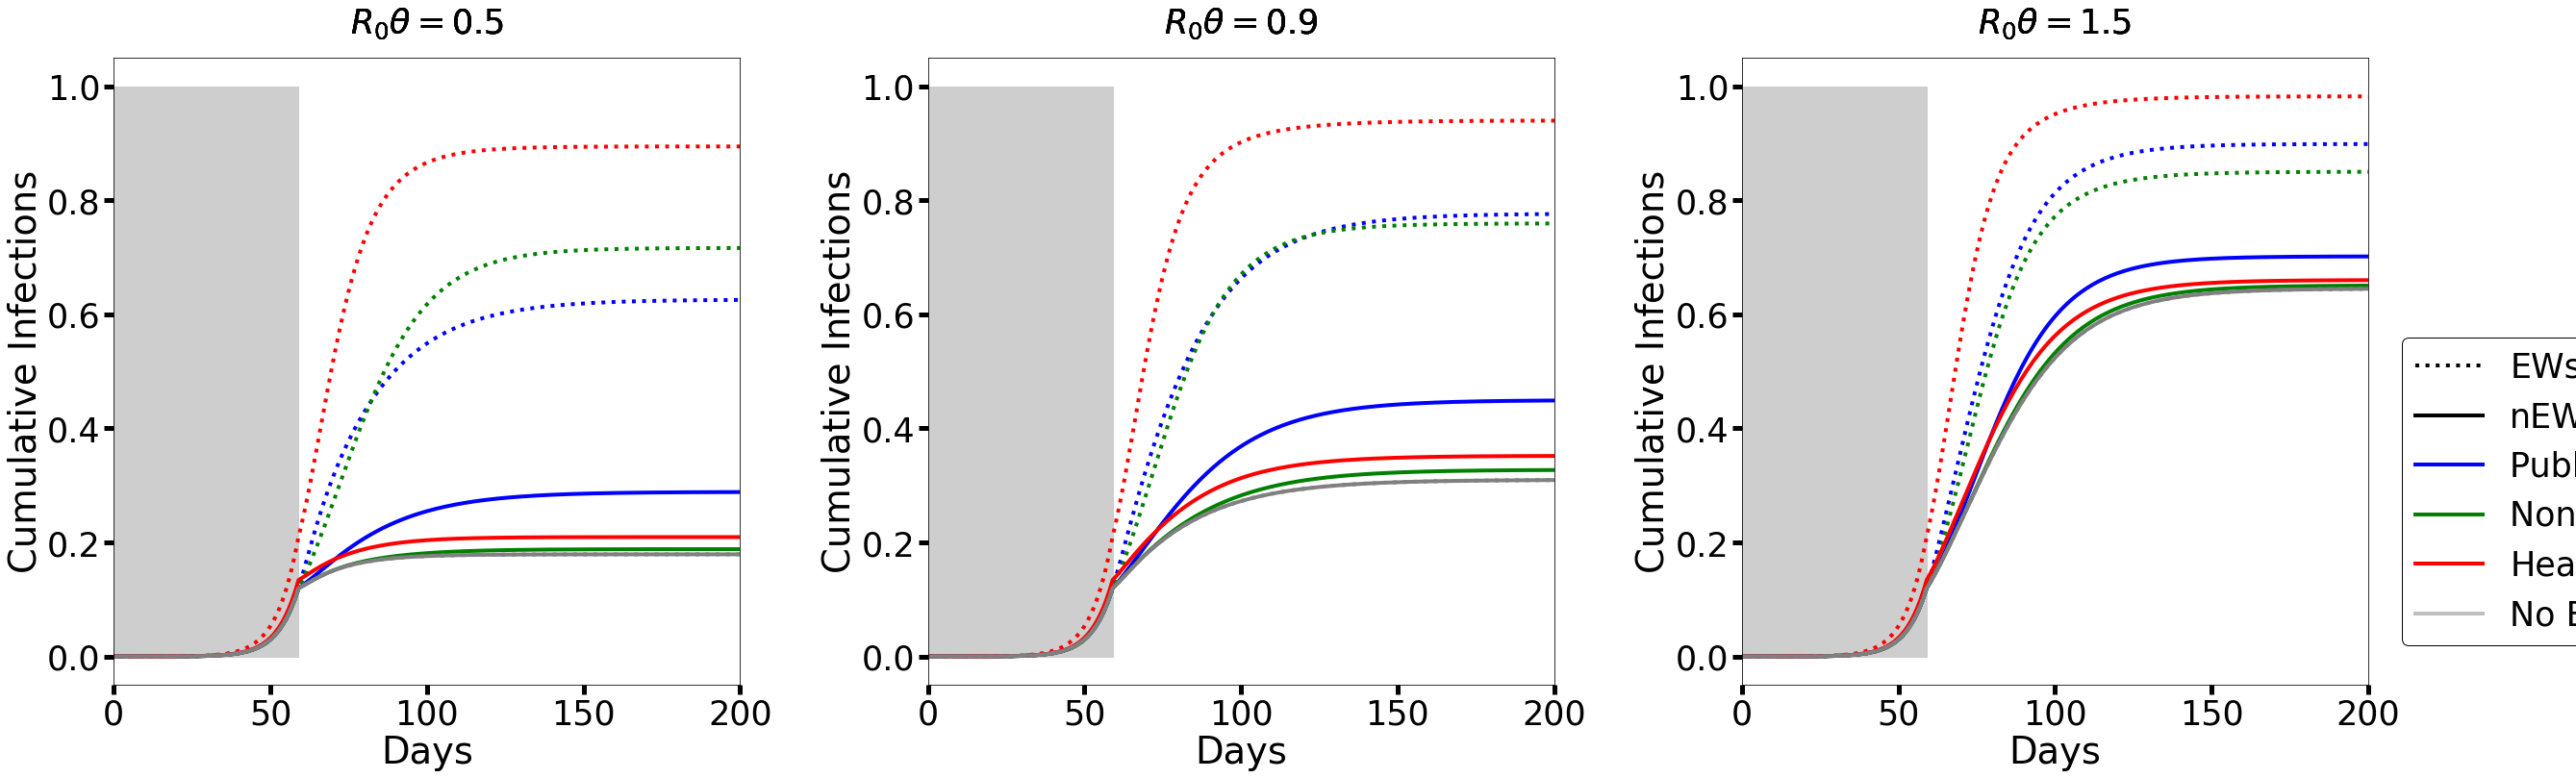

In [33]:
# Make plot for Figure 2
desired_Reff = np.array([0.5,0.9,1.5])
R_0 = R0_from_doubling_time(args_default,3)
print('t',(1-desired_Reff/R_0))

plt.rc('legend', fontsize=30)
plot_grid(theta_values = desired_Reff/R_0,
          f_values     = [0.05],
          max_days     = 400,
          metric       = 'All_Infection',
          R_0          = R_0,
          I0           = 20,
          t_lockdown   = 59,
          models       = ['Cashier','USPS','Healthcare','No Structure'],
          model_dependent_rho = {'No Structure': 0,
                                   'Cashier': 0,
                                   'Healthcare': 0.5,
                                   'USPS': 0.5,
                                   'Healthcare_Sigmoid':  0},
          linewidth    = 4,
          adjust_beta_hosp = 9.5649565,
          font_size=35)

First, we can examine the effect that increasing the proportion $f$ of the population that is considered an essential worker has on the cumulative infection rate. The following plot shows what happens for $f=0.10$ (instead of $f=0.05$ as in the main text), which yields qualitatively similar results.

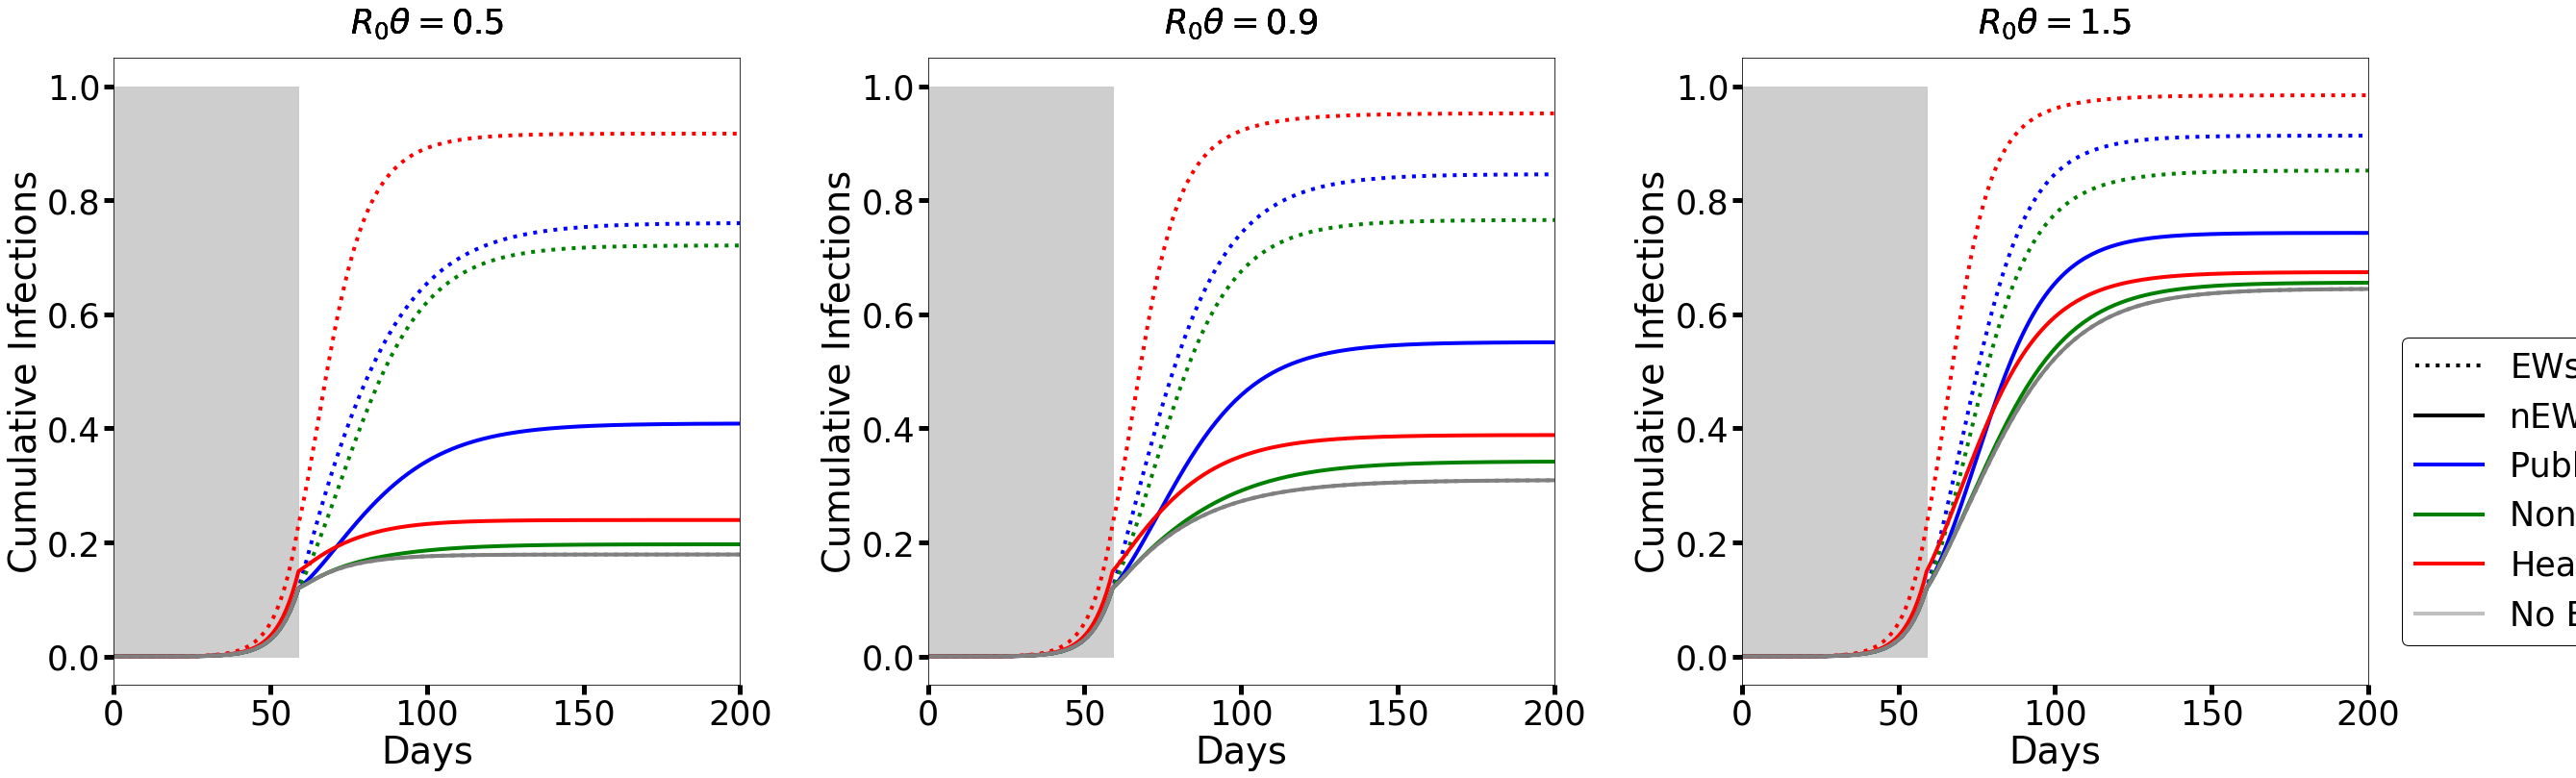

In [34]:
# Make a similar plot to Figure 2, but change f
plt.rc('legend', fontsize=30)
plot_grid(theta_values = desired_Reff/R_0,
          f_values     = [0.10],
          max_days     = 400,
          metric       = 'All_Infection',
          R_0          = R_0,
          I0           = 20,
          t_lockdown   = 59,
          models       = ['Cashier','USPS','Healthcare','No Structure'],
          model_dependent_rho = {'No Structure': 0,
                                   'Cashier': 0,
                                   'Healthcare': 0.5,
                                   'USPS': 0.5,
                                   'Healthcare_Sigmoid':  0},
          linewidth    = 4,
          adjust_beta_hosp = 9.5649565,
          font_size=35)

Additionally, we can change the time of the lockdown relative to the pandemic progression. Below is a similar plot for $f=0.05$, but with a lockdown time 10 days earlier. The qualitative conclusions outlined in the main text remain the same.

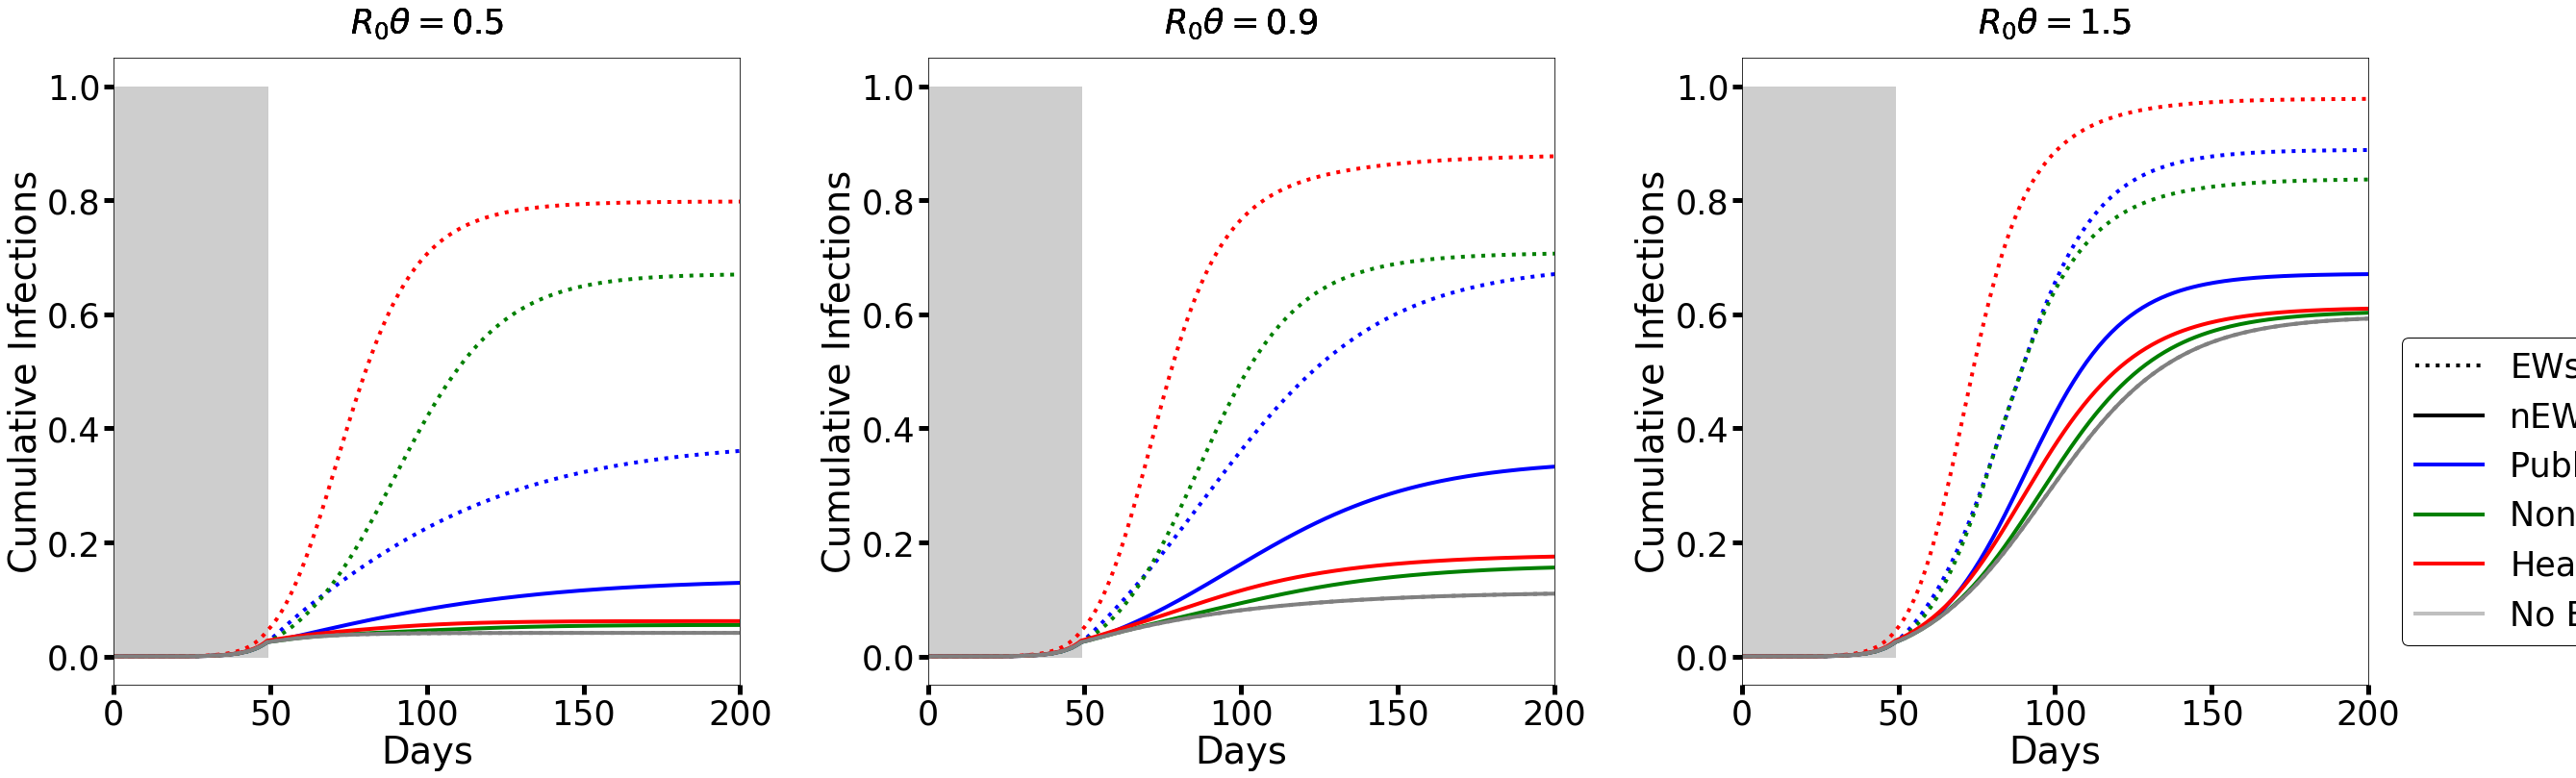

In [35]:
# Make a similar plot to Figure 2, but change t_lockdown
plt.rc('legend', fontsize=30)
plot_grid(theta_values = desired_Reff/R_0,
          f_values     = [0.05],
          max_days     = 400,
          metric       = 'All_Infection',
          R_0          = R_0,
          I0           = 20,
          t_lockdown   = 59 - 10,
          models       = ['Cashier','USPS','Healthcare','No Structure'],
          model_dependent_rho = {'No Structure': 0,
                                   'Cashier': 0,
                                   'Healthcare': 0.5,
                                   'USPS': 0.5,
                                   'Healthcare_Sigmoid':  0},
          linewidth    = 4,
          adjust_beta_hosp = 9.5649565,
          font_size=35)

### Figure 3 - Heatmaps of cumulative infections
Next, we can plot the cumulative infections after a year in the total population and in each class of worker as a heatmap for combinations of $\theta$ and $f$. To do so, we need to iterate over a grid of $\theta$ and $f$ values and solve the model for each combination. The functions below run these iterations and set up the plotting area for the heatmaps:

In [36]:
# Run several models over different values of theta and f
# Here, we look at theta between 0 and 1, and f between 0 and 0.25
def run_iterations(model_names, theta_values = np.linspace(0,1,21),f_values = np.linspace(0,0.25,21),
                   R_0 = 2.5, t_lockdown = 59, n_infected = 50, n_exposed = 50, max_days = 1000, 
                   change_in_p_IH = 1, change_in_p_IA = 1, doubling_time = None, rho = 9.5649565):
    
    results_dict = {}

    # For each of the specified models
    for model in model_names:
        
        print(model)
        results_dict[model] = {}
        
        if model == 'USPS' or model == 'Healthcare':
            rho = 0.5
        else: 
            rho = 0
            
        # For each of the given f values (f = fraction essential)
        for f in f_values:
            
            # f can't be 0
            if f == 0: continue
            
            #print('\t',f)
            results_dict[model][f] = {}
            
            # for each of the given theta values (theta = effectiveness of social distancing)
            for theta in theta_values:
                
                # run the model and record the results
                results_dict[model][f][theta] = run_model(theta = theta,
                                                            R_0 = R_0,
                                                            t_lockdown=t_lockdown,
                                                            model=model,
                                                            n_infected=n_infected,
                                                            n_exposed=n_exposed,
                                                            prop_essential=f,
                                                            max_days = max_days,
                                                            rho = rho,
                                                            change_in_p_IH = change_in_p_IH,
                                                            change_in_p_IA = change_in_p_IA,
                                                            adjust_beta_hosp = f*rho)
            
    return results_dict

def assign_row_label_figure3(ax,model, pad = 25, xy = (0,0.5), model_labels = model_labels,font_size = 12):
        
    # Adds the text to left of the subplot
    ax.annotate(model_labels[model], xy=xy, xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=font_size, ha='right', va='center',rotation=90)
    
def assign_column_label_figure3(ax,text,index, pad = 5, xy = (0.5,1),font_size=12):
    letter_maps = {0: 'A',
                   1: 'B',
                   2: 'C'}
    
    label = letter_maps[index] + ': ' + text
    pad = 5 # in points
    ax.annotate(label+'\n', xy=xy, xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=font_size, ha='center', va='baseline')

    
def plot_heatmap(sol_dict,model_names = ['No Structure','Cashier','USPS'],
                       Xname = '',Yname = '',font_size = 30,center_point = None):

    update_font_size(font_size)
    # The models we are plotting heatmaps for
    model_keys = list(sol_dict.keys())
    # 
    variable_1_keys = np.sort([i for i in sol_dict[model_keys[0]].keys()])
    variable_2_keys  = np.sort([i for i in sol_dict[model_keys[0]][variable_1_keys[0]].keys()])
            
    fig, axes_all = plt.subplots(len(model_names),3,figsize=[45,10*len(model_names)])
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
    # Only considering 2 metrics
    for metric in range(3):
        
        # Name of the metrics and levels to plot contour curves for
        metric_names = {0:('Total infections after one year',[center_point]),
                        1:('Infections among non-essentials',[]),
                        2:('Infections among essential workers',[])}
        
        metric_name,levels = metric_names[metric]
        
        # Get the axis for this model
        axes = [row_axes[metric] for row_axes in axes_all]

        # Create a matrix to build the heatmaps from 
        sol_array = np.zeros([len(model_keys),len(variable_1_keys),len(variable_2_keys)])
    
        for i,model in enumerate(model_names):
            
            # Reformat keys to look nice
            axis_1_keys = []
            axis_2_keys = []
            
            # Get R0 to convert from theta to r0(theta)
            R0 = R0_from_doubling_time(args_default,3)
            for index,key1 in enumerate(variable_1_keys):
                axis_1_keys.append(round(R0*(key1),2))
                    
            for index,key2 in enumerate(variable_2_keys):
                axis_2_keys.append(key2)

            # Fill in the matrix
            model_dict = sol_dict[model]
            for j,(var1,var1_dict) in enumerate(model_dict.items()):
                for k,(var2,solutions) in enumerate(var1_dict.items()):
                    sol_array[i,j,k] = solutions[metric]
                    
            plt.sca(axes[i])
            # Get the relevant part of the matrix and orientate the matrix correctly (tranpose then flip vertically)
            data = np.flip(np.transpose(sol_array[i,:,:]))
            data = pd.DataFrame(data)
            data.index = np.flip(axis_2_keys)
            data.columns = axis_1_keys
            # Make a heatmap from it
            HM = heatmap(data=data,
                         yticklabels=5,xticklabels=5,
                         cmap = 'Spectral',
                         center = center_point,
                         vmin = 0,
                         vmax = 1,
                         cbar_ax=cbar_ax)
            
            CS = plt.contour(data,levels=levels,colors='r',linewidths=6)
            plt.yticks(rotation=0)
            axes[i].tick_params(width = 5,length = 10)
            
            # Label heatmaps with model names 
            model_labels = {'Cashier'             :'Public Facing',
                            'USPS'                :'Non-Public Facing',
                            'Healthcare'          :'Healthcare',
                            'No Structure'        :'No essential workers',
                            'Healthcare_Sigmoid'  :'Healthcare'}
            
            if i == 0:
                assign_column_label_figure3(ax=axes[i],text = metric_name, index = metric,font_size=font_size)
            if metric == 0:
                assign_row_label_figure3(ax=axes[i],model = model,font_size=font_size)
                
            # Set variable names on the axis
            if Yname:
                axes[i].set_ylabel(Yname)
            if Xname:
                axes[i].set_xlabel(Xname)
                
          
    cbar_ax.tick_params(width = 5,length = 10)
    fig.subplots_adjust(hspace=0.3,wspace=0.3,right = 0.825)
    plt.show()

The following block of code reproduces the heatmaps depicted in Figure 3 of the main text. Here, we are assuming a lockdown time of 59 days.

Cashier
USPS
Healthcare


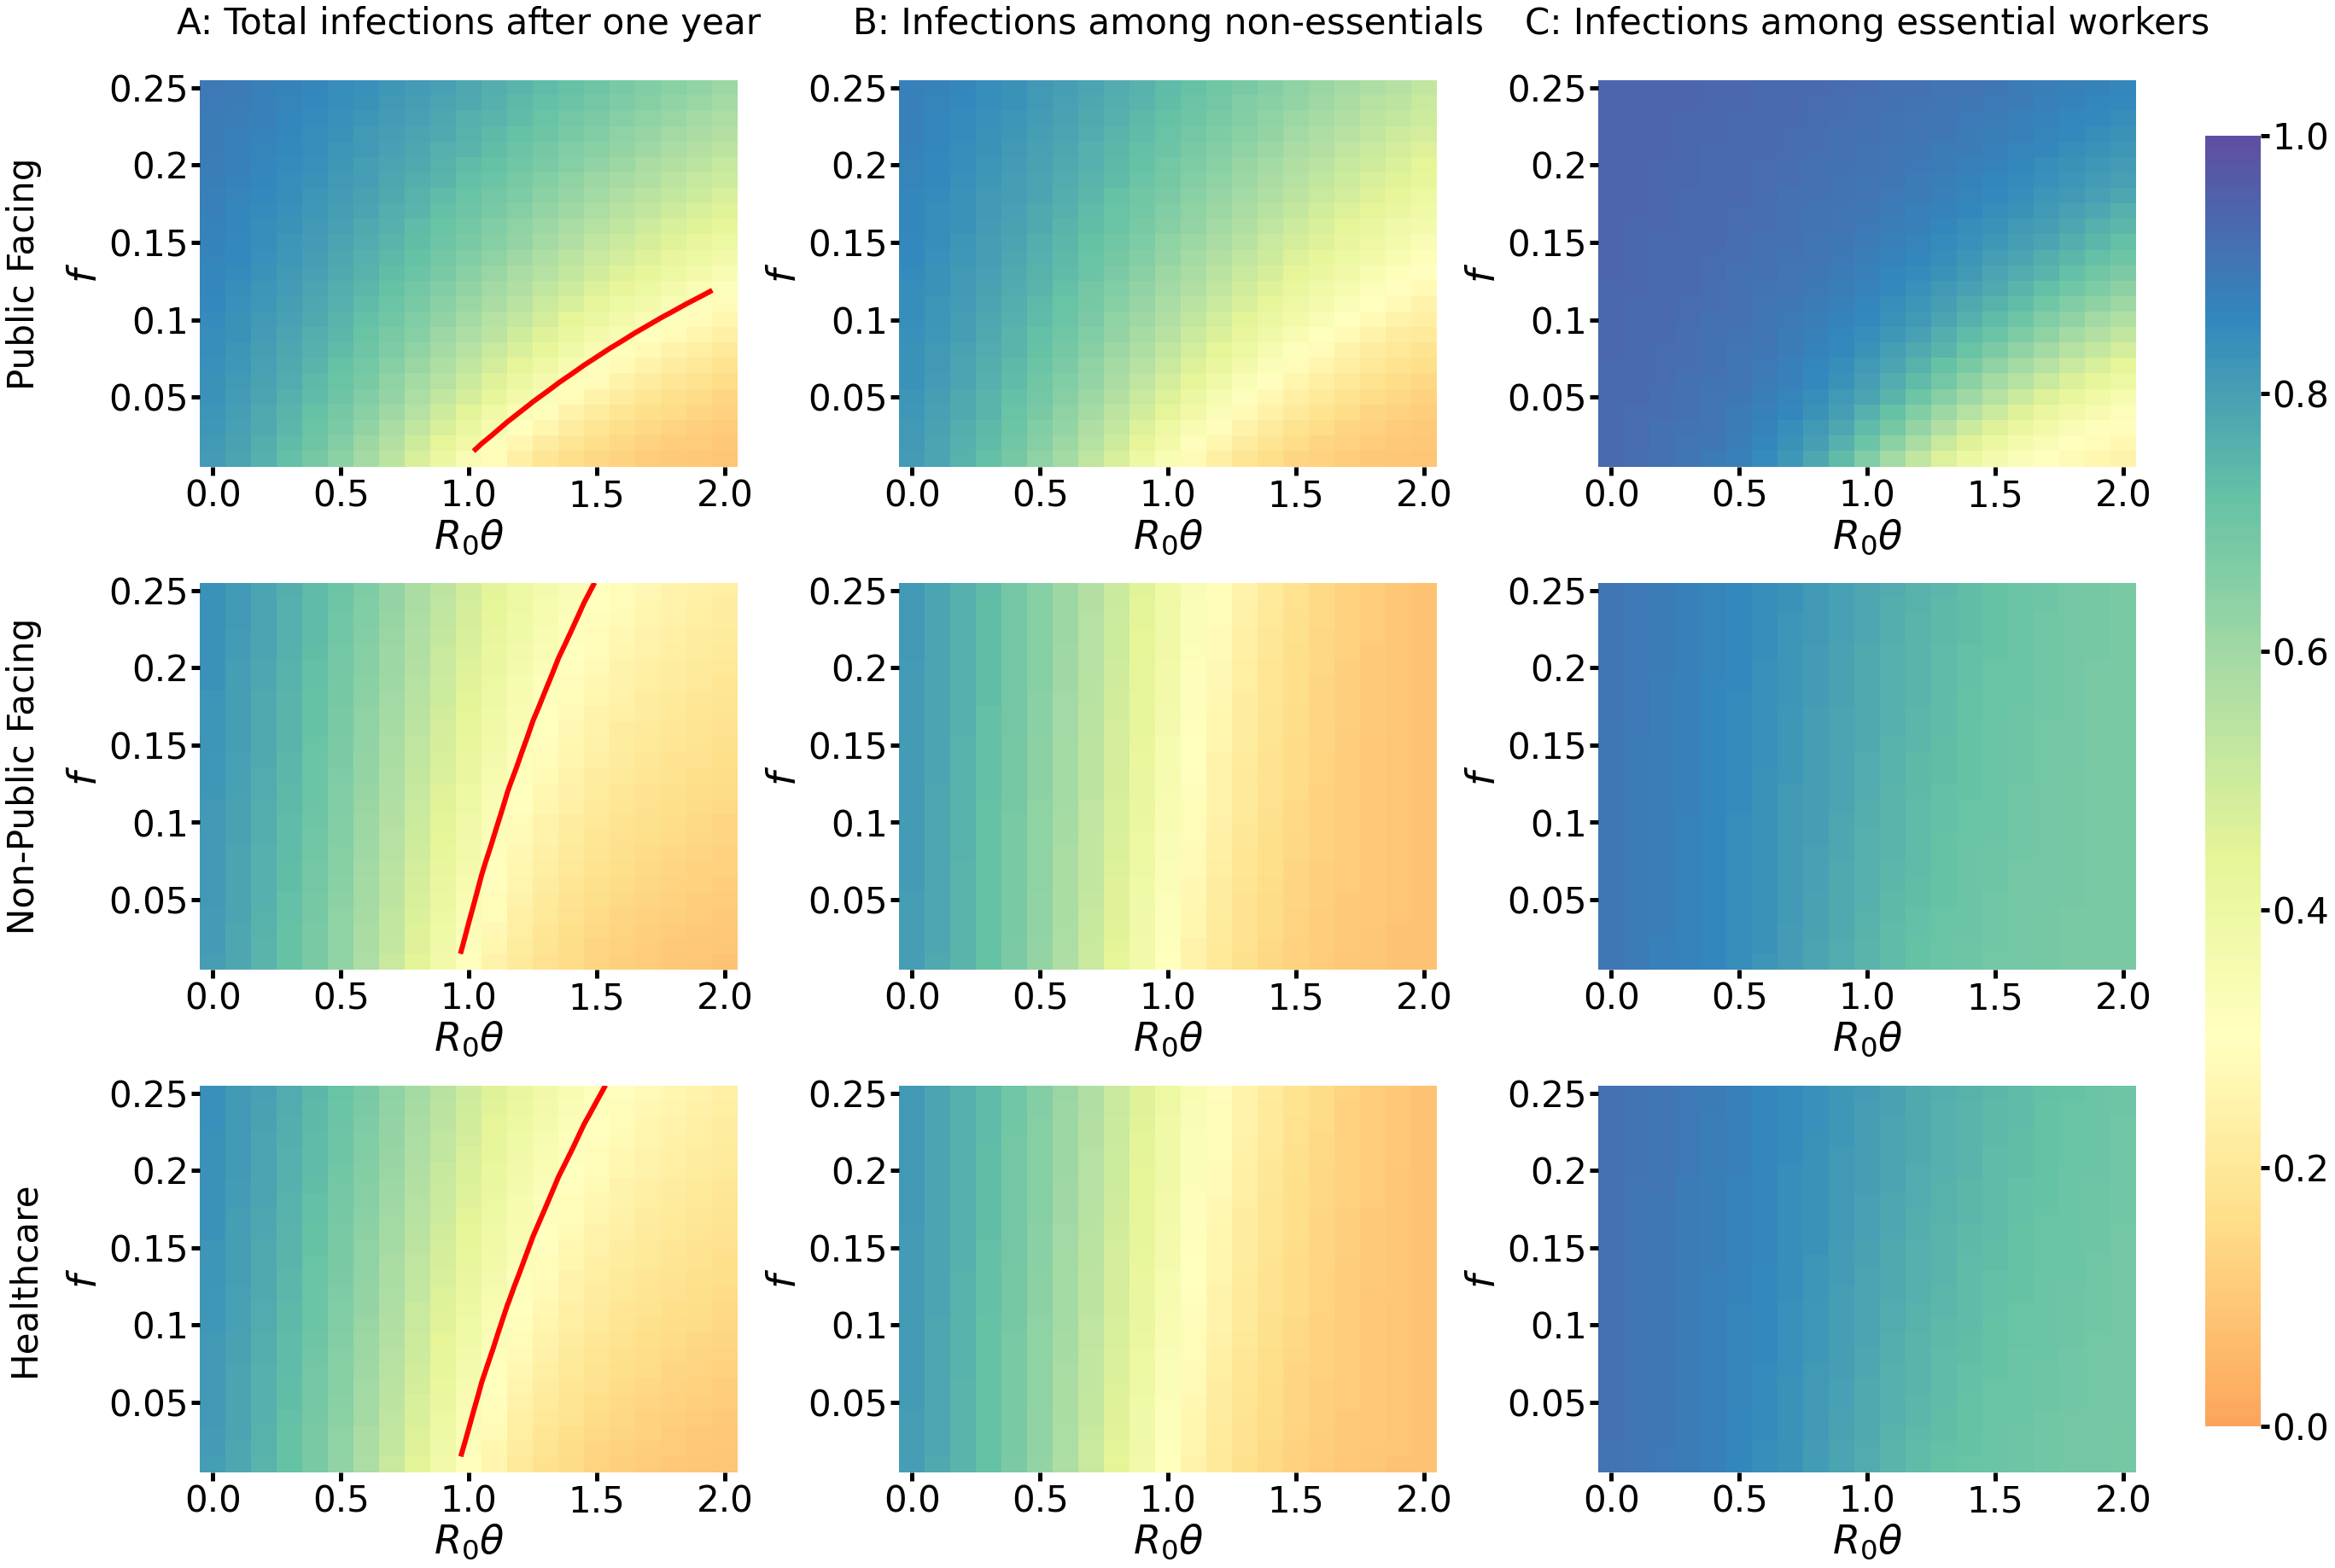

In [37]:
keep_R0_constant = False
# Get R_0 assuming a doubling time of 3 days
R_0 = R0_from_doubling_time(args_default,3)
R_0_values = np.linspace(2,0,21)

# Get the values of theta and f to iterate over
# Only use values of theta such that R0(theta) < 2
theta_values=np.sort(R_0_values/R_0)
f_values = np.linspace(0,0.25,26)
all_results_phaseDiagram2 = run_iterations(theta_values=theta_values,
                                          f_values = f_values,
                                          R_0 = R_0,
                                          n_exposed = 0,
                                          n_infected = 20,
                                          model_names = ['Cashier','USPS','Healthcare'])
# Make the plot for Figure 3
# This takes the resulting model solutions and converts them to the metrics we want
solved_results = get_metrics(all_results_phaseDiagram2)
# This plots the metrics we want as a heatmap.
sol, pp = run_model(t_lockdown=59,theta = (1/R_0),R_0 = R_0, n_exposed = 0, n_infected = 20, rho = 0,model = 'No Structure',prop_essential=0.05)
center_point = get_infection_rate(solution=sol,p=pp, time = 365)
plot_heatmap(solved_results,Yname=r'$f$',Xname=r'$R_0\theta$',model_names = ['Cashier','USPS','Healthcare'],font_size = 42,center_point = center_point)

Qualitatively similar results are obtained if the lockdown date is changed to be ten days earlier. 

Cashier
USPS
Healthcare


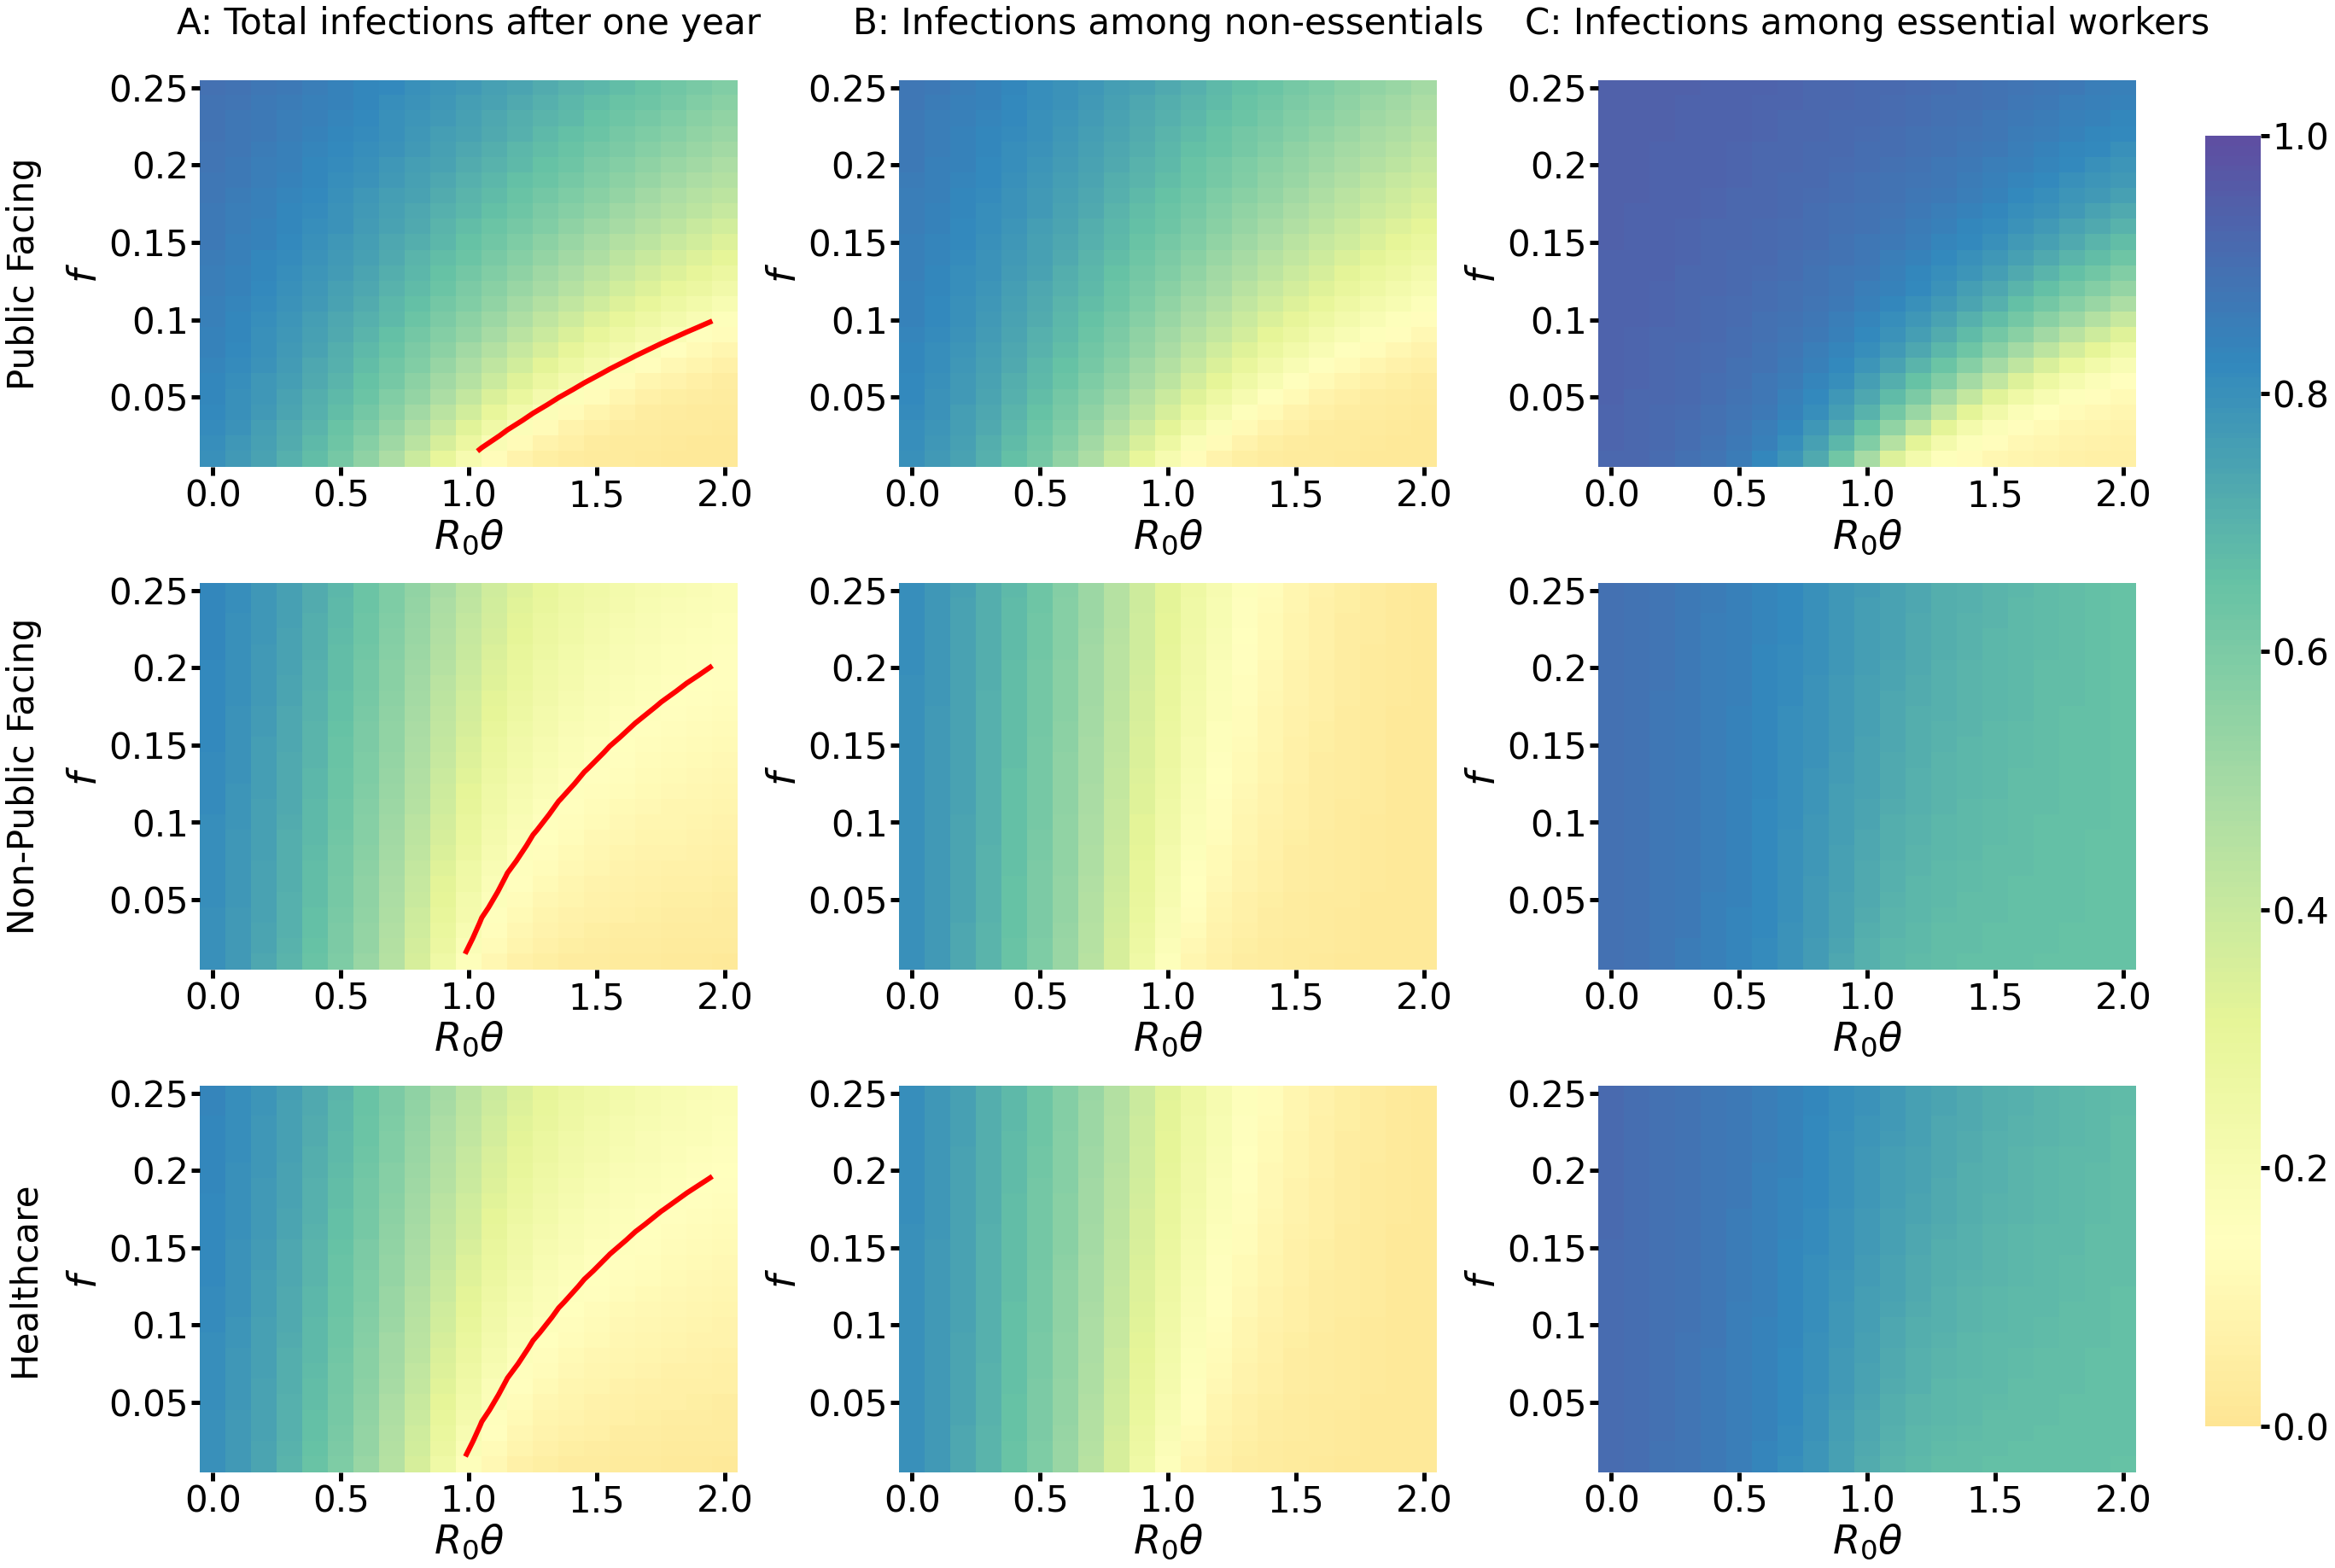

In [38]:
# Get the values of theta and f to iterate over
# Only use values of theta such that R0(theta) < 2
theta_values=np.sort(R_0_values/R_0)
f_values = np.linspace(0,0.25,26)
all_results_phaseDiagram2 = run_iterations(theta_values=theta_values,
                                          f_values = f_values,
                                          R_0 = R_0,
                                          n_exposed = 0,
                                          n_infected = 20,
                                          t_lockdown=49, # Changing the lockdown date
                                          model_names = ['Cashier','USPS','Healthcare'])
# Make the plot for Figure 3, but with the t_lockdown moved 10 days earlier
# This takes the resulting model solutions and converts them to the metrics we want
solved_results = get_metrics(all_results_phaseDiagram2)
# This plots the metrics we want as a heatmap.
sol, pp = run_model(t_lockdown=49,theta = (1/R_0),R_0 = R_0, n_exposed = 0, n_infected = 20, rho = 0,model = 'No Structure',prop_essential=0.05)
center_point = get_infection_rate(solution=sol,p=pp, time = 365)
plot_heatmap(solved_results,Yname=r'$f$',Xname=r'$R_0\theta$',model_names = ['Cashier','USPS','Healthcare'],font_size = 42,center_point = center_point)

### Figure 4 - Time-resolved dynamics of infections
In Figure 4 of the main text, we show the time-resolved dynamics of infections for $f=0.05$ and $R_0\theta=0.5$. The following code defines functions to calculate the time-resolved proportion of essential and non-essentials that are infected, the fraction of infected individuals that are essential workers, and the proportion of new infections for different routes of transmission.

In [39]:
# Assign row and column labels for the plots of the effective R over time
def assign_row_label_figure4(ax,model,letter,pad = 5, xy = (0,0.5),letter_pad = 0):
    if not letter_pad:
        letter_pad = pad*20
    ax.annotate(letter, xy=xy, xytext=(-ax.yaxis.labelpad - letter_pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='center', va='center',rotation=0)
        
    ax.annotate(model+'\n', xy=xy, xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='center', va='center',rotation=90)
    
# Label is the value of R_effective
def assign_column_label_figure4(ax,model, pad = 5, xy = (0.5,1)):
    text = model_labels[model]
    pad = 5 # in points
    ax.annotate(text+'\n', xy=xy, xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
# Get the three metrics to plot in Figure 4
def get_figure4_metrics(solution_matrix,p):
    
    # Fraction of population an essential worker
    f     = p.proportion_essential
    
    # Proportion infected in each group
    I_t_0   = sum(solution_matrix[0,2:5,:])
    I_t_1   = sum(solution_matrix[1,2:5,:])
    
    # G(t): proportion of infected that are essential workers
    G_t = (I_t_1)/(I_t_0+I_t_1)
    
    # Find the effects of social distancing. Second variable is from a different implementation
    social_distancing_effect = get_effect_of_social_distancing(p,None)
    
    # beta is R_0 * mean infectious time
    # This is the same beta across all infectious compartments and groups
    nointervention_beta = get_infectious_beta(p)
    
    # Get the within hospital beta and calculate number of within hospital infections. 0 if not a healthcare model
    if 'Healthcare' in p.model:
        hosp_beta = get_hosp_beta(t='None',p=p,H='None')
    else:
        hosp_beta = 0
    print(hosp_beta)
    within_hosp_infections = hosp_beta * sum(sum(solution_matrix[:,5:10,:])) * solution_matrix[1,0,:] / (p.N*f)
    
    t = np.arange(p.max_days)
    new_infections = np.zeros([2,2,p.max_days])
    people_distribution = [1-f,f]
    for j in t:
        
        # Calculate betas. This is elementwise multiplication not matrix multiplication
        betas = nointervention_beta*(p.C)
        if j>p.social_distancing_time:
            betas = betas*(social_distancing_effect)
        
        # Include extra effect from within group mixing
        betas[1,1] += get_extra_rho_effect(j,p,1) * nointervention_beta
        
        for i in [0,1]:
            for k in [0,1]:
                new_infections[i,k,j] = betas[k,i] * sum(solution_matrix[i,2:5,j]) * (solution_matrix[k,0,j]) / (p.N*people_distribution[k])
        
        total_infections = sum(sum(new_infections[:,:,j]))+within_hosp_infections[j]
        new_infections[:,:,j] = new_infections[:,:,j]/total_infections
        within_hosp_infections[j] = within_hosp_infections[j]/total_infections
    return G_t, (I_t_0/(p.N*(1-f)), I_t_1/(p.N*f)), new_infections,within_hosp_infections

# Make model labels a global so we can access anywhere
model_labels = {'Cashier'         :'Public Facing',
                'USPS'        :'Non-Public Facing',
                'Healthcare'  :'Healthcare',
                'No Structure':'No essential workers',
                'Healthcare_Sigmoid'  :'Healthcare'}

# Function to plot the metrics
def create_figure4(theta, models, t_lockdown, max_days = 500,R_0=2.5,I0=50,adjust_beta_hosp = 9.5,
                   figsize = (30,10),model_dependent_f = None,model_dependent_rho = None, linewidth = 2,
                   xlim = 250,legend_keywords = {'framealpha': 1, 
                                                 'edgecolor':'k'}):
    
    fig,  axes_all = plt.subplots(3, len(models),figsize=(12*len(models),30))
    (axes_I,axes_G,axes_B) = axes_all
    # Plotting LS and color for each model
    ls_styles = {'No Structure':('-',[0,0,0,0.5]),
                 'Cashier':(':',[0,0,1,1]),
                 'Healthcare':('--','r'),
                 'USPS':('-.','g'),
                 'Healthcare_Sigmoid':('-.','purple')}
    
    legend_entries = {}
    max_values_r = ddict(float)
    max_values_g = ddict(float)
    for model_index,model in enumerate(models):
            
            # If doing multiple theta values, unpack axes
            if len(models) > 1:
                ax_G = axes_G[model_index]
                ax_I = axes_I[model_index]
                ax_B = axes_B[model_index]
            else:
                ax_G = axes_G
                ax_I = axes_I
                ax_B = axes_B
                
            # Get f and rho for each model
            f1 = model_dependent_f[model]
            rho1 = model_dependent_rho[model]
            
            # run model and reshape output
            solution,p = run_model(theta = theta,
                                     R_0 = R_0,
                                     t_lockdown = t_lockdown,
                                     model = model,
                                     n_infected = I0,
                                     n_exposed  = 0,
                                     prop_essential = f1,
                                     max_days = max_days,
                                     rho = rho1,
                                     adjust_beta_hosp = adjust_beta_hosp*f1)   
            
            solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])
            
            # Get the effective R, betas, and g(t) 
            G_t, I_t, new_infections, within_hosp_infections = get_figure4_metrics(solution_matrix,p)
            
            # Get color for each model but don't use LSs
            ls, color = ls_styles[model]
            ls = '-'
            
            # Plot g(t)
            plt.sca(ax_G)
            plt.hlines([f1],xmin = t_lockdown, xmax = p.max_days,color = [0.5,0.5,0.5,0.5],ls = '-',linewidth = linewidth,label='No difference')
            plt.plot(np.arange(0,max_days),G_t,ls = '-',color='k',linewidth = linewidth)
            plt.xlabel("Days")
            plt.fill_between(y1=(0,0),y2=(1,1),x=(0,t_lockdown),color=[0.8,0.8,0.8,0.5])
            plt.ylim([0,1.0])
            plt.xlim([0,xlim])
            if model_index == len(models) - 1:
                plt.legend(loc='upper left',
                           bbox_to_anchor = (0.56, 0.95),
                            **legend_keywords)
            
            # Plot I(t)
            I_styles = {0:('Non-essentials','-'),1:('Essentials',':')}
            plt.sca(ax_I)
            
            for groupID in range(2):
                label,ls = I_styles[groupID]
                ax_I.plot(np.arange(0,max_days),I_t[groupID],color = 'k',linewidth = linewidth,ls=ls,label=label)
            
            ax_I.set_xlabel("Days")
            ax_I.set_xlim([0,xlim])
            ax_I.set_yscale('log')
            plt.fill_between(y1=(0,0),y2=(1,1),x=(0,t_lockdown),color=[0.8,0.8,0.8,0.5])
            plt.ylim([1e-6,2e-1])
            if model_index == len(models) - 1:
                plt.legend(**legend_keywords,
                           loc='upper left',
                           bbox_to_anchor = (0.56, 0.95))
            
            # Plot where new infections come from
            plt.sca(ax_B)
            B_styles = {0:{0:('xkcd:tomato','-','NN'),
                           1:('xkcd:tomato',':','NE')},
                        1:{0:('xkcd:dodger blue','-','EN'),
                           1:('xkcd:dodger blue',':','EE')}}
            
            for infectious_groupID in [0,1]:
                for susceptible_groupID in [0,1]:
                    color,ls,label = B_styles[infectious_groupID][susceptible_groupID]
                    plt.plot(np.arange(0,max_days),new_infections[infectious_groupID,susceptible_groupID,:],color = color,linewidth = linewidth,ls=ls,label=label)
                    if infectious_groupID == 0 and susceptible_groupID == 1:
                        plt.plot([],[],color=[0,0,0,0],label=' ')
            plt.plot(np.arange(0,max_days),within_hosp_infections,color = 'xkcd:dark sea green',linewidth = linewidth,ls='--',label='WH')
            plt.xlabel("Days")
            plt.xlim([0,xlim])
            plt.ylim([1e-3,1.1])
            plt.yscale('log')
            plt.fill_between(y1=(0,0),y2=(2,2),x=(0,t_lockdown),color=[0.8,0.8,0.8,0.5])
            if model_index == len(models) - 1:
                plt.legend(loc = 'upper left', 
                           bbox_to_anchor = (0.56, 0.65),
                           **legend_keywords,ncol = 2)
            
            # Assign a column label
            assign_column_label_figure4(axes_I[model_index],p.model)
    assign_row_label_figure4(axes_I[0],'Prevalence','A',letter_pad = 120)
    assign_row_label_figure4(axes_G[0],'EW Fraction of Infected','B',pad=50,letter_pad = 150)
    assign_row_label_figure4(axes_B[0],'Proportion of\nNew Infections','C',letter_pad = 120)
    for ax in axes_all.flat:
        ax.tick_params(width = 5, length = 10)
        ax.tick_params(width = 2.5, length = 5,which='minor')
    plt.subplots_adjust(wspace=0.25,hspace=0)

    plt.tight_layout()
    plt.show()

The code below reproduces Figure 4 from the main text:

0
0
0.3078070891649127


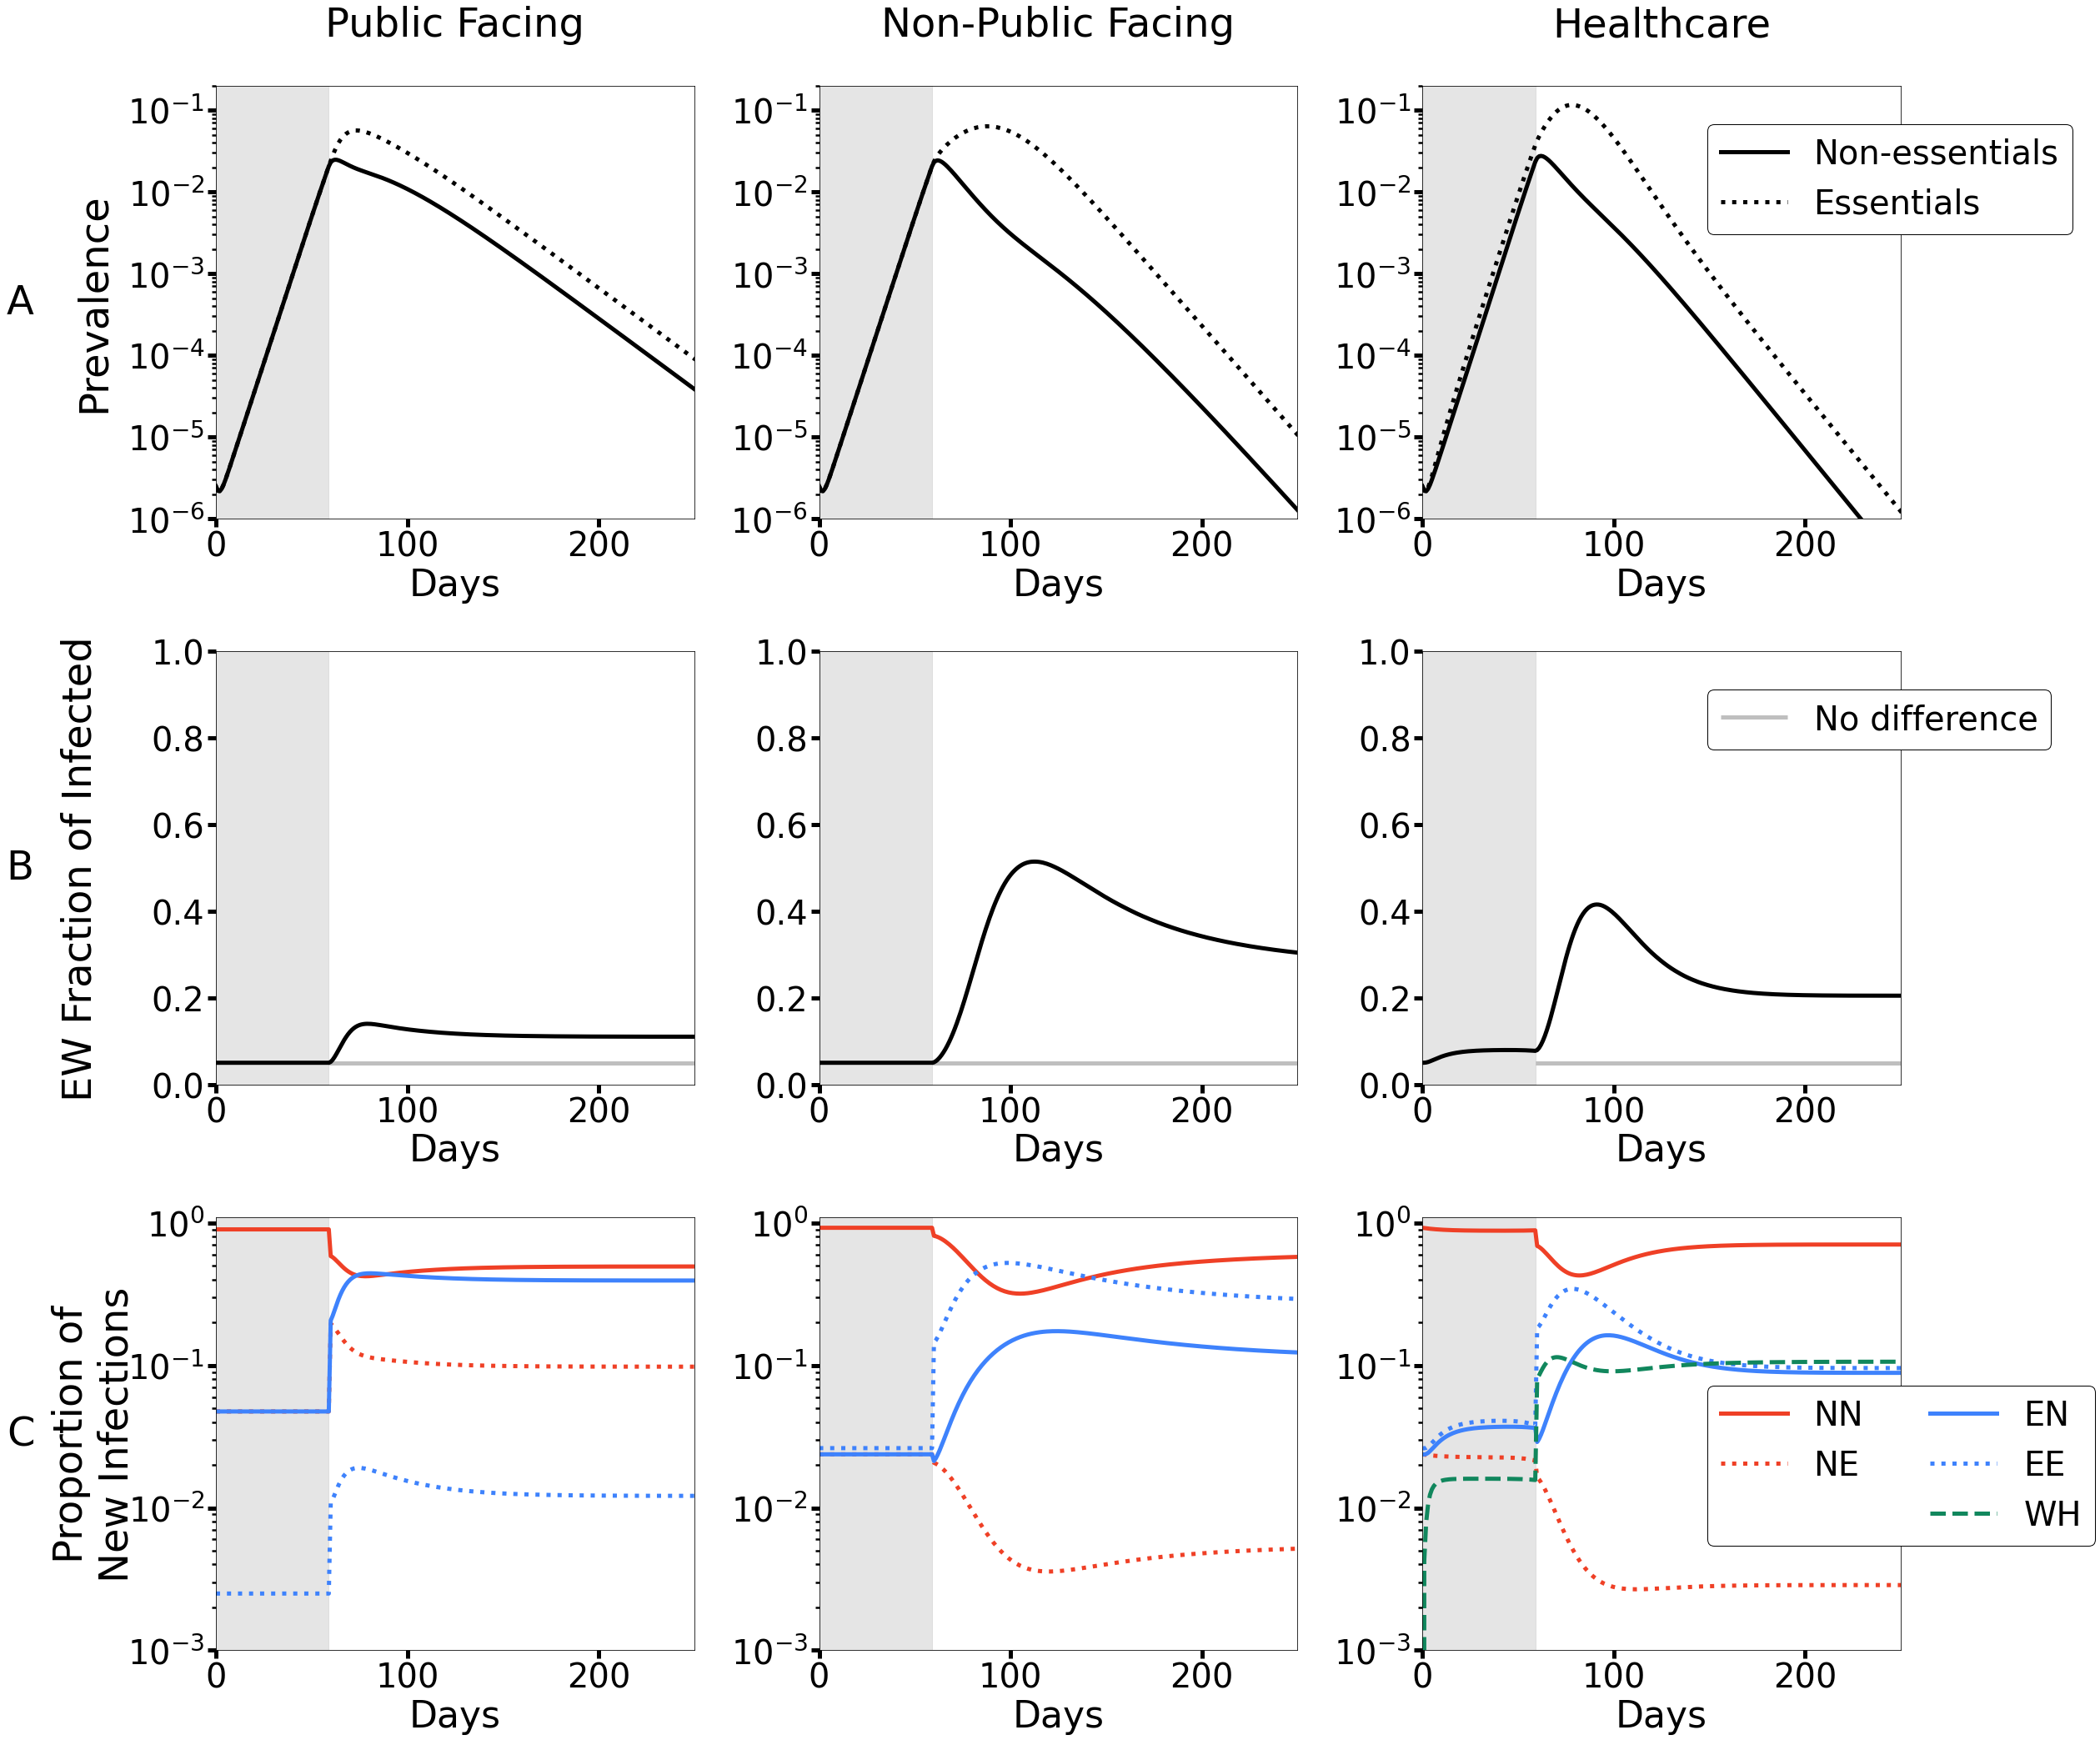

In [40]:
# Choose theta values such that R_0*(theta) is some specified number
desired_Reff = 0.5
R_0 = R0_from_doubling_time(args_default,3)
keep_R0_constant = False

update_font_size(40)
create_figure4(theta =(desired_Reff/R_0),
               max_days = 400,R_0=R_0,I0=20,
               t_lockdown = 59,
               models = ['Cashier','USPS','Healthcare'],
               model_dependent_f = {'No Structure':       0.05,
                                    'Cashier':            0.05,
                                    'USPS':               0.05,
                                    'Healthcare':         0.05,
                                    'Healthcare_Sigmoid': 0.05},
                 
               model_dependent_rho = {'No Structure': 0,
                    'Cashier': 0,
                    'Healthcare': 0.5,
                    'USPS': 0.5,
                    'Healthcare_Sigmoid':  0},
               linewidth = 5,
               adjust_beta_hosp = 9.5649565)

In the figure below, we change the lockdown date to 10 days earlier in the pandemic progression. Qualitatively similar results are obtained.

0
0
0.3078070891649127


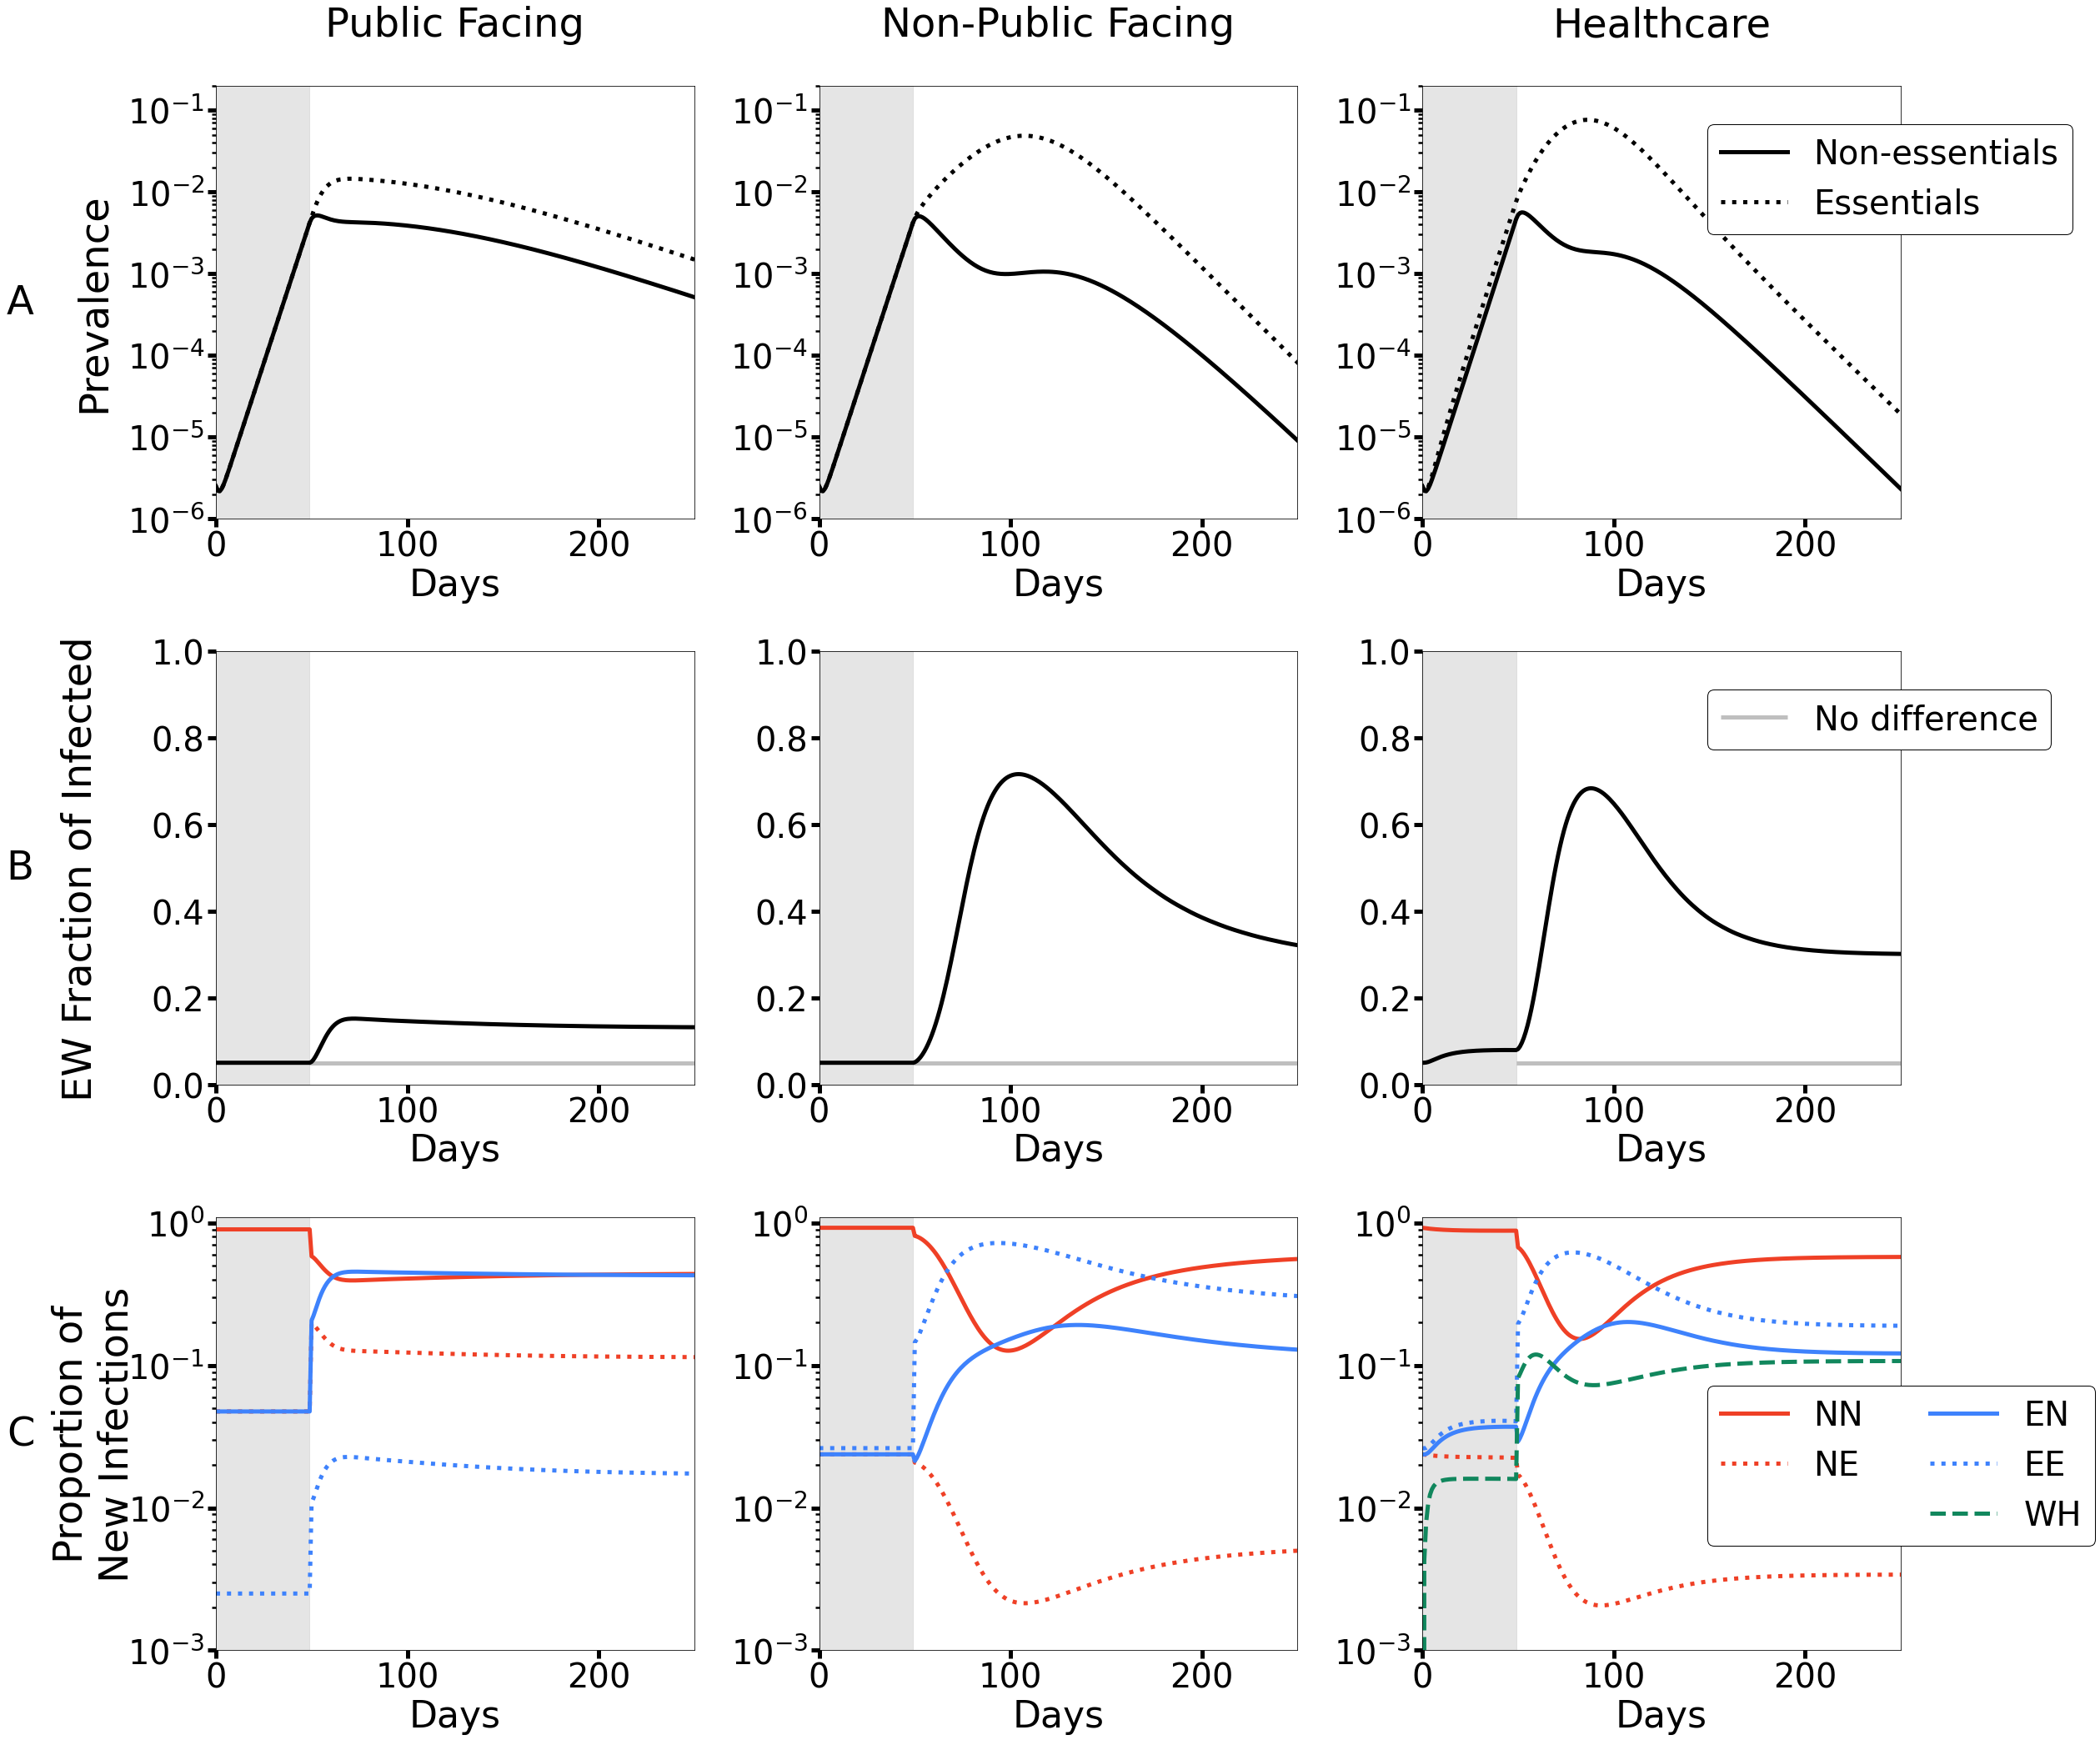

In [41]:
# Choose theta values such that R_0*(theta) is some specified number
desired_Reff = 0.5
R_0 = R0_from_doubling_time(args_default,3)
keep_R0_constant = False

update_font_size(40)
create_figure4(theta =(desired_Reff/R_0),
               max_days = 400,R_0=R_0,I0=20,
               t_lockdown = 49, # Change lockdown to be 10 days earlier
               models = ['Cashier','USPS','Healthcare'],
               model_dependent_f = {'No Structure':       0.05,
                                    'Cashier':            0.05,
                                    'USPS':               0.05,
                                    'Healthcare':         0.05,
                                    'Healthcare_Sigmoid': 0.05},
                 
               model_dependent_rho = {'No Structure': 0,
                    'Cashier': 0,
                    'Healthcare': 0.5,
                    'USPS': 0.5,
                    'Healthcare_Sigmoid':  0},
               linewidth = 5,
               adjust_beta_hosp = 9.5649565)

### Fitting to empirical data

Although the goal of this work is not to model the outbreak in a particular city/region or use it to make quantitative predictions, we can assess how well the parameter choices and the overall model match the progression of the ongoing pandemic by fitting to empirical data. Following others, we focus on the number of deaths rather than of cases, because (although not without problems) these numbers seem more reliable. Here, we use publically available cumulative deaths for three U.S. cities: Seattle, Chicago, and New York City. As a starting point to focus on a more reliable subset of the data, we remove the most recent 2 days and all dates before the 10th reported death.

For New York City, we note that while both confirmed and probable deaths due to Covid-19 are reported, probable deaths were not added until March 11th, and over 4500 were added __[retroactively](https://web.stanford.edu/~chadj/sird-paper.pdf)__ in mid-April. Even these are likely an __[under-estimate](https://www.nytimes.com/interactive/2020/04/27/upshot/coronavirus-deaths-new-york-city.html)__ as more than 4200 deaths remain unexplained. 

In the code block below, we read in and format publically available data on Covid-19 deaths (and hospitalizations for NYC).

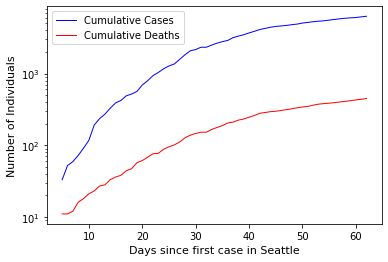

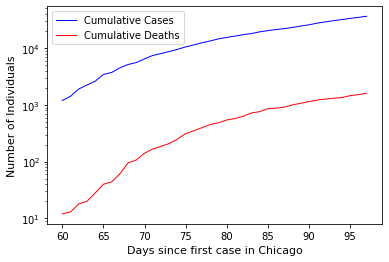

In [60]:
# The fits are using data that is current on 5/3/2020
# Read in Seattle data
# Source for all US counties: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
counties_cases = pd.read_csv("~/us-counties.csv")
counties_cases.rename(columns={'date':'DATE_OF_INTEREST'}, inplace=True)
counties_cases['DATE_OF_INTEREST'] = pd.to_datetime(counties_cases['DATE_OF_INTEREST'])
seattle_cases = counties_cases[counties_cases['county']=='King']
seattle_cases = seattle_cases[seattle_cases['state']=='Washington']
seattle_cases.reset_index(drop=True, inplace=True)
nrows = seattle_cases.shape[0]
seattle_cases = seattle_cases.drop([nrows-1,nrows-2])
seattle_cases["cumulative_cases"] = seattle_cases["cases"]
seattle_cases["cumulative_deaths"] = seattle_cases["deaths"]
first_date = seattle_cases['DATE_OF_INTEREST'][0]
seattle_cases["day_num"] = (seattle_cases['DATE_OF_INTEREST'] - first_date).dt.days.astype(int)
day_of_tenth_death = seattle_cases[seattle_cases["cumulative_deaths"]>10].DATE_OF_INTEREST.iloc[0]
seattle_cases = seattle_cases[seattle_cases["DATE_OF_INTEREST"]>=(day_of_tenth_death)]
seattle_cases.reset_index(drop=True, inplace=True)
#print(seattle_cases.head())

# Create Chicago data
chicago_cases = counties_cases[counties_cases['county']=='Cook']
chicago_cases = chicago_cases[chicago_cases['state']=='Illinois']
chicago_cases.reset_index(drop=True, inplace=True)
nrows = chicago_cases.shape[0]
chicago_cases = chicago_cases.drop([nrows-1,nrows-2])
chicago_cases["cumulative_cases"] = chicago_cases["cases"]
chicago_cases["cumulative_deaths"] = chicago_cases["deaths"]
first_date = chicago_cases['DATE_OF_INTEREST'][0]
chicago_cases["day_num"] = (chicago_cases['DATE_OF_INTEREST'] - first_date).dt.days.astype(int)
day_of_tenth_death = chicago_cases[chicago_cases["cumulative_deaths"]>10].DATE_OF_INTEREST.iloc[0]
chicago_cases = chicago_cases[chicago_cases["DATE_OF_INTEREST"]>=(day_of_tenth_death)]
chicago_cases.reset_index(drop=True, inplace=True)
#print(chicago_cases.head())

# Read in NYC data
# Cases, hospitalization data: https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv
# Probable deaths: https://raw.githubusercontent.com/nychealth/coronavirus-data/master/probable-confirmed-dod.csv
# Read in NYC data
nyc_cases = pd.read_csv("~/case-hosp-death.csv")
nrows = nyc_cases.shape[0]
nyc_cases = nyc_cases.drop([nrows-1,nrows-2])
# Replace NA with 0
nyc_cases = nyc_cases.fillna(0)
nyc_cases['DATE_OF_INTEREST'] = pd.to_datetime(nyc_cases['DATE_OF_INTEREST'])
first_date = nyc_cases['DATE_OF_INTEREST'][0]
nyc_cases["day_num"] = (nyc_cases['DATE_OF_INTEREST'] - first_date).dt.days.astype(int)
nyc_cases["cumulative_cases"] = nyc_cases["CASE_COUNT"].sort_index().cumsum()
nyc_cases["cumulative_hospitalized"] = nyc_cases["HOSPITALIZED_COUNT"].sort_index().cumsum()

nyc_prob_deaths = pd.read_csv("~/probable-confirmed-dod.csv") #Read in probable deaths
nyc_prob_deaths = nyc_prob_deaths.fillna(0)
nyc_prob_deaths['DATE_OF_INTEREST'] = pd.to_datetime(nyc_prob_deaths['date_of_death'])
nyc_cases = nyc_cases.merge(nyc_prob_deaths, on='DATE_OF_INTEREST')
nyc_cases["all_deaths"] = nyc_cases["CONFIRMED_COUNT"] + nyc_cases["PROBABLE_COUNT"]
nyc_cases["cumulative_deaths"] = nyc_cases["all_deaths"].sort_index().cumsum()
day_of_tenth_death = nyc_cases[nyc_cases["cumulative_deaths"]>10].DATE_OF_INTEREST.iloc[0]
nyc_cases = nyc_cases[nyc_cases["DATE_OF_INTEREST"]>=(day_of_tenth_death)]
#print(nyc_cases.head())

# Make plots showing real data in Seattle
update_font_size(10,rcParams = mpl.rcParams)
plt.plot(seattle_cases.day_num, seattle_cases.cumulative_cases, color='blue', linewidth=1, label='Cumulative Cases')
plt.plot(seattle_cases.day_num, seattle_cases.cumulative_deaths, color='red', linewidth=1, label='Cumulative Deaths')
plt.xlabel('Days since first case in Seattle')
plt.ylabel('Number of Individuals')
plt.legend(loc='best')
plt.yscale('log')
plt.show() 

# Make plots showing real data in Chicago
plt.plot(chicago_cases.day_num, chicago_cases.cumulative_cases, color='blue', linewidth=1, label='Cumulative Cases')
plt.plot(chicago_cases.day_num, chicago_cases.cumulative_deaths, color='red', linewidth=1, label='Cumulative Deaths')
plt.xlabel('Days since first case in Chicago')
plt.ylabel('Number of Individuals')
plt.legend(loc='best')
plt.yscale('log')
plt.show() 



# Reset the indexes for all locations
nyc_cases.reset_index(drop=True, inplace=True)
seattle_cases.reset_index(drop=True, inplace=True)
chicago_cases.reset_index(drop=True, inplace=True)

The "steps" in the Chicago data correspond to a weekend effect, where reported deaths are decreased for Saturdays and Sundays

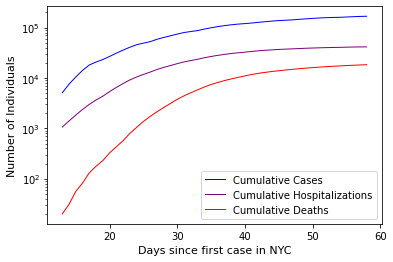

In [59]:
# Make plots showing real data in New York City
plt.plot(nyc_cases.day_num, nyc_cases.cumulative_cases, color='blue', linewidth=1, label='Cumulative Cases')
plt.plot(nyc_cases.day_num, nyc_cases.cumulative_hospitalized, color='purple', linewidth=1, label='Cumulative Hospitalizations')
plt.plot(nyc_cases.day_num, nyc_cases.cumulative_deaths, color='red', linewidth=1, label='Cumulative Deaths')
plt.xlabel('Days since first case in NYC')
plt.ylabel('Number of Individuals')
plt.legend(loc='best')
plt.yscale('log')
plt.show() 

The function below is used to compute the error of the model during the optimization procedure. Here, we are minimizing the root-mean-square-error (RMSE) of the per-day change in the death count. In the optimization presented below, we are inferring $R_0$, $\theta$, the starting time of the infection, and the time of lockdown relative to the first case. 

In [71]:
def SEIR_model_loss(params_to_estimate, data, n_forecast, model, lockdown_t, start_t, N=8e6, fit_hospital=False, adjust_beta_hosp=1, rho=1,   error=True):
    
    # Parameters passed from optimization algorithm
    R_0, theta, lockdown_t = params_to_estimate[0:3]
    pred_infected = 20
    
    if theta < 0 or R_0 < 0 or lockdown_t < 0 or start_t < 0:
        return np.inf
    # Get actual data
    n_infected = data['cumulative_cases']
    n_deaths = data['cumulative_deaths']
    
    # Number of days that we have data for
    n_train = data.shape[0]
    
    # Define how many days to simulate
    max_days = n_forecast

    # Define proportion essential
    prop_essential = 0.1
    
    # Number of groups
    num_groups = 2
    
    # Define the compartments
    compartment_names = ["S","E","IA","IR","IH","HR","HC","CR","CD","L","R","D"]
    compartment_formulas = [dS_dt,dE_dt,dIA_dt,dIR_dt,dIH_dt,dHR_dt,dHC_dt,dCR_dt,dCD_dt,dL_dt,dR_dt,dD_dt]
    compartments = namedtuple("compartments",compartment_names)

    # Define the initial conditions & population size
    n_exposed  = 0
    N = N

    # Social interaction effects: C
    # C[i][j] = proportion of group I's contacts that are with group 
    # rho allows deviations from proportionate mixing
    C = np.array([    (1 - prop_essential) + rho * prop_essential,
                      (1 - rho) * (1 - prop_essential),
                      (1 - rho) * (prop_essential),
                      1 - (1 - rho) * (1 - prop_essential) - rho])                              
    C = np.reshape(C,[num_groups,num_groups])    
    
    # Convert initial state into 1-dimensional array
    
    t_span = [0, max_days]
    t_eval = np.arange(max_days)
    
    social_distancing_time = lockdown_t
    args = parameters(R_0 = R_0,                             # R_0: used to calculate betas
                      N = N,                                 # total population size
                      C = C,                                 # Mixing matrix

                      social_distancing_time = social_distancing_time,   # when does social distancing start
                      theta = theta,                         # How effective is social distancing
                      model = model,                         # Who social distances?
                      proportion_essential = prop_essential, #
                      rho = rho,                         # record changes from proportionate mixing

                      max_days = max_days,                   # bookkeeping of how many days simulated
                      num_groups = num_groups,               # bookkeeping of how many groups
                      compartment_names = compartment_names, # bookkeeping of how many compartments

                      t_inc =  4.6,   # !time from E to I: exposed to infected
                      t_AR =   5,   # !time from IA to R: infected and asymptomatic to recovered
                      t_IR =  5,   # !time from IR to R: infected, symptomatic and will recover to recovered
                      t_IH =  5,   # !time from IH to H: infected and will need hospitalization to hospitalization
                      t_HR =  8,   # !time from HR to R: hospitalized and will recover to recovered
                      t_HC =   6,   # !time from HC to C: hospitalization to critical care
                      t_CD =   10,# time from CD to D: critical care and will die to death
                      t_CL =   7,   # time from CR to L: critical care and will recover to post-critical care hospitalization
                      t_LR =  3,   # time from L to R: post-critical care hospitalization to recovered

                      p_IA = 1/3, # Proportions of infections that are asymptomatic
                      p_IH = 0.066, # Proportion of symptomatic infections that require hospitalizations, conditional on not being asymptomatic
                      p_HC = 0.3, # Proportion of hospitalizations that require critical care
                      p_CD = 0.5, # Proportion of critical cases that are fatal
                      change_in_p_IH = 1, # How much is the probability of hopsitalization increased in OLD
                      change_in_p_IA = 1, # How much is the probability of asymptomatic increased in OLD
                      adjust_beta_hosp = adjust_beta_hosp) # change the beta for within hospital interactions relative to beta between I and S
    
    single_population    = np.zeros(len(compartment_names))
    single_population[1] = n_exposed
    
    single_population[2] = pred_infected*args.p_IA
    single_population[3] = pred_infected*(1-args.p_IA)*(1-args.p_IH)
    single_population[4] = pred_infected*(1-args.p_IA)*(args.p_IH)
    single_population[0] = N - sum(single_population)
    initial_state        = [(1 - prop_essential) * single_population,
                            prop_essential * single_population]
    # Convert initial state into 1-dimensional array
    initial_state = [params for group in initial_state for params in group]
    
    sol = solve_ivp(lambda t,y: SEIR_HCD_model(t,y,args), t_span, initial_state, t_eval=t_eval,method = 'Radau')
    pred_all = np.maximum(sol.y, 0)
    pred_all = get_compartment_counts(sol, num_groups)
        
    min_loss = np.inf
    best_start = 0
    
    for i in range(int(lockdown_t)):
        begin_time = i
        n_train = len(n_deaths)
        # Get Predicted Deaths and Hospitalization from days that we want to fit to
        pred_cases, pred_hosp, pred_deaths = pred_all[0], pred_all[1], pred_all[2]
        pred_deaths_eval = pred_deaths[begin_time: n_train + begin_time]
        
        # Use only if we want to also fit to the hospitilization curve (only useful for NYC)
        if fit_hospital == True:
            n_hospitilized = data['cumulative_hospitalized']
            pred_hosp_eval = pred_hosp[begin_time: n_train + begin_time]
            n_hospitilized_diffs = np.ediff1d(n_hospitilized, to_begin=n_hospitilized[0])[1:]
            pred_hosp_eval_diffs = np.ediff1d(pred_hosp_eval, to_begin=pred_hosp_eval[0])[1:]
            hosp_rmse = np.sqrt(mean_squared_error(n_hospitilized_diffs, pred_hosp_eval_diffs))
            
        n_deaths_diffs = np.ediff1d(n_deaths, to_begin=n_deaths[0])[1:]
        pred_deaths_eval_diffs = np.ediff1d(pred_deaths_eval, to_begin=pred_deaths_eval[0])[1:]

        deaths_rmse = np.sqrt(mean_squared_error(n_deaths_diffs, pred_deaths_eval_diffs))
        
        if fit_hospital == True:
            loss = hosp_rmse
            
        else:
            loss = deaths_rmse
            
        if loss < min_loss:
            min_loss = loss
            best_start = i
            best_pred_cases, best_pred_hosp, best_pred_deaths = pred_cases, pred_hosp, pred_deaths
    
    if error == True:
        return min_loss
    
    else:
        return min_loss, best_start, best_pred_cases[best_start:], best_pred_hosp[best_start:], best_pred_deaths[best_start:]
    

We use a hierarchical optimization approach. First, we use Latin Hypercube Sampling to generate random starting points for the parameters to infer. Next, we use Nelder-Mead optimization for the intial guesses to obtain a good starting point for a final standard descent optimization with the L-BFGS algorithm. This process is repeated 5 times and the parameters with the minimal loss are taken as the final value.

In [62]:
def fit_SEIR_model(data, model, N=8.1e6, fit_hospital=False):

    # decide how many days to forcast
    n_forecast = 250
    
    min_loss = np.inf
    best_parameters = None
    
    # Model, Initial values, and bounds on parameters
    print(model)
    
    # R_0, theta, I0
    x0 = [1, 0, 0, 0]
    
    # Loop over potential times for lockdown
    for i in [50]:#np.arange(25,75):
        for _ in range(5):
            print('\t',i)
            
            # bounds on R_0, theta
            bounds = ((1, 10),(0, 1),(30,80),(0,0))
            mm = len(x0)
            
            simplex = lhs(mm,(mm+1),'center')
            for ii,(minv,maxv) in enumerate(bounds):
                simplex[:,ii] = simplex[:,ii]*(maxv-minv)+minv
                            
            print(simplex)

            bounds = ((1, 10),(0, 1),(30,80),(0,0))
            # Find the optimal set of parameters given model and parameter values and bounds
            res = minimize(fun = SEIR_model_loss,
                           x0 = x0,
                           method = 'Nelder-Mead',
                           options = {'initial_simplex':simplex},
                           args=(data, n_forecast, model, i, 0, N, fit_hospital))
            
            res = minimize(fun = SEIR_model_loss,
               x0 = res.x,
               bounds = bounds,
               args=(data, n_forecast, model, i, 0, N, fit_hospital))
            

            R_0, theta, lockdown_t  = res.x[0:3]

            # Simulate data with given parameters and returns outcomes: error, predicted cases, predicted deaths, and predicted deaths
            # j in the best start day (how many days since the first infection until the first case in NYC data)
            err, j,pred_cases, pred_hosp, pred_deaths = SEIR_model_loss(res.x, data=data, n_forecast=n_forecast, model=model, 
                                                                      lockdown_t=i,start_t=0,error=False, N=N, fit_hospital=fit_hospital)
            
            # Print the best parameters for a given lockdown day
            print('\t\t', j, R_0, theta, err)
            
            # If this new set of parameters is the best one, save it
            if err < min_loss:
                start_t = j
                lockdown_t = i
                best_parameters = res.x
                min_loss = err

    R_0, theta = best_parameters[0:2]
    estimate_text = '\tR_0 = {}\n\t'.format(round(R_0,2)) + \
                'theta = {}\n\t'.format(round(theta,3)) + \
                'lockdown_time = {}\n\t'.format(round(lockdown_t,1)) + \
                'start_time = {}'.format(round(start_t,1))
    print(estimate_text)
    
    err, start_t, pred_cases, pred_hosp, pred_deaths = SEIR_model_loss(best_parameters, 
                                                                       data=data,
                                                                       n_forecast=n_forecast, 
                                                                       model=model, 
                                                                       lockdown_t=lockdown_t,
                                                                       start_t=start_t, 
                                                                       error=False, N=N,fit_hospital=fit_hospital)
    # Concatenate actual and predicted values into one dataframe
    # Get dates relating actual data to predicted data
    n = len(pred_cases)
    
    dates_all = [str(datetime.strptime(data['DATE_OF_INTEREST'].astype(str)[0], '%Y-%m-%d') + timedelta(days = ii))[0:10] for ii in range(n)]
    predictions = pd.DataFrame({'ConfirmedCases_pred': pred_cases, 'Fatalities_pred': pred_deaths,'Hospitilized_pred': pred_hosp}, index = dates_all)
    
    actuals = data[['DATE_OF_INTEREST','cumulative_cases','cumulative_deaths']]
    if fit_hospital == True:
        actuals = data[['DATE_OF_INTEREST','cumulative_cases','cumulative_deaths','cumulative_hospitalized']]
    actuals.DATE_OF_INTEREST = actuals.DATE_OF_INTEREST.astype(str)
    actuals.set_index('DATE_OF_INTEREST', inplace=True)
    # Merge the two dataframes
    plot_df = pd.merge(predictions, actuals, how='left', left_index=True, right_index=True)
         
    return((R_0,theta,lockdown_t,start_t), plot_df)

# Here we are only fitting the 'No Structure' model. However, other valid models can be inserted into the list below
models = ['No Structure']
fitting_results_nyc = {}
fitting_results_seattle = {}
fitting_results_chicago = {}

for model in models:
    param_estimate, plot_df = fit_SEIR_model(nyc_cases, model)
    fitting_results_nyc[model] = (param_estimate, plot_df)
    
for model in models:
    param_estimate, plot_df = fit_SEIR_model(seattle_cases, model, N=2.2e6)
    fitting_results_seattle[model] = (param_estimate, plot_df)
    
for model in models:
    param_estimate, plot_df = fit_SEIR_model(chicago_cases, model, N=5e6)
    fitting_results_chicago[model] = (param_estimate, plot_df)

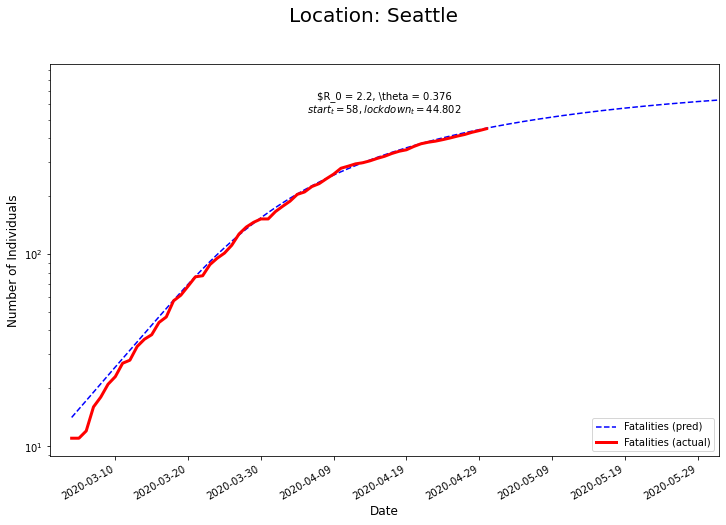

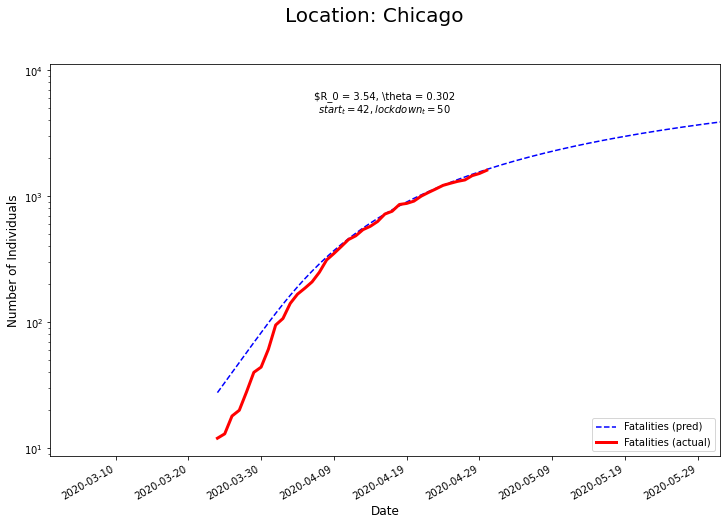

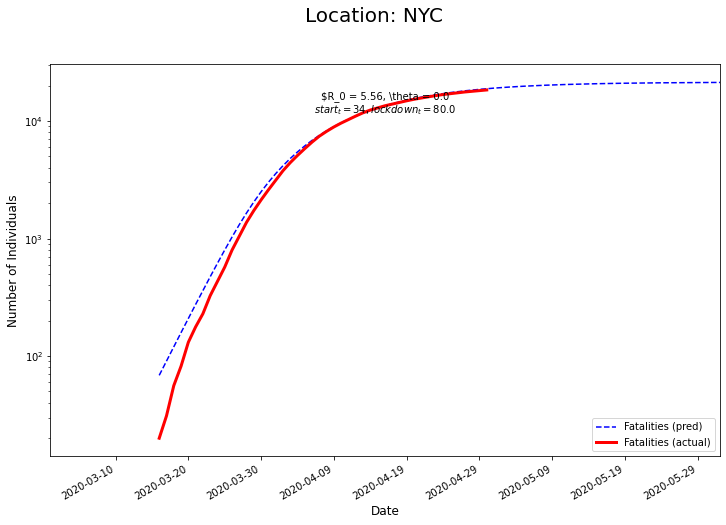

In [63]:
# The function below can be used to display the predicted and actual death curves for a give city/location
update_font_size(10,rcParams = mpl.rcParams)
import matplotlib.dates as mdates
from datetime import datetime, date
def plot_model_fits(fitting_results: dict, location, fit_hospital = False):
    models = list(fitting_results.keys())

    param_estimate = fitting_results['No Structure'][0]
    plot_df = fitting_results['No Structure'][1]
    
    plot_df['DATE_OF_INTEREST'] = plot_df.index
    plot_df['DATE_OF_INTEREST'] = pd.to_datetime(plot_df['DATE_OF_INTEREST'])
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    if fit_hospital == False:
        plt.plot(plot_df.DATE_OF_INTEREST,plot_df.Fatalities_pred.values, color='blue',linestyle='--', linewidth=1.5, label='Fatalities (pred)')
        plt.plot(plot_df.DATE_OF_INTEREST,plot_df.cumulative_deaths.values, color='red', label='Fatalities (actual)',ls='-',linewidth=3)

    else:
        plt.plot(plot_df.DATE_OF_INTEREST,plot_df.Hospitilized_pred.values, color='blue',linestyle='--', linewidth=1.5, label='Hospitalizations (pred)')
        plt.plot(plot_df.DATE_OF_INTEREST,plot_df.cumulative_hospitalized.values, color='orange', label='Hospitalizations (actual)',ls='-',linewidth=3)
    plt.gcf().autofmt_xdate()
    
    fig.suptitle('Location: ' + location, fontsize=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Individuals', fontsize=12)
    plt.legend(loc='lower right')
    plt.xlim([date(2020, 3, 1), date(2020, 6, 1)])
    plt.yscale('log')
    
    #print(param_estimate)
    R_0,theta,lockdown_t,start_t = param_estimate
    estimate_text = r'$R_0 = {}, \theta = {}'.format(round(R_0,2),round(theta,3)) + '\n' + r'$start_t = {}, lockdown_t = {}$'.format(round(start_t,3),round(lockdown_t,3))

    plt.text(0.5,0.9,estimate_text,horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    
    
    plt.show()

#Plot the fits for Seattle, Chicago and NYC sequentially
plot_model_fits(fitting_results_seattle, "Seattle")
plot_model_fits(fitting_results_chicago, "Chicago")
plot_model_fits(fitting_results_nyc, "NYC")

In the plots above, the observed number of deaths is shown in red and the predictions from a model with no structure in blue. As can be seen, a good fit and plausible parameter estimates are obtained for data from Chicago and Seattle. A reasonable fit is also seen for New York City, but in this case, parameter estimates are not so sensible (notably $\theta$=0), possibly because the data are less reliable (see above). Given these possible issues, and the fact that New York City also provides hospitalization counts, we instead explored fitting our model to the cumulative hospitalizations for this case.

In [75]:
models = ['No Structure']
fitting_results_hosp_nyc = {}
#nyc_hosp_cases = nyc_cases[nyc_cases['DATE_OF_INTEREST']> '3/11/2020']
#nyc_hosp_cases.reset_index(drop=True, inplace=True)

for model in models:
    param_estimate, plot_df = fit_SEIR_model(nyc_cases, model, fit_hospital=True)
    fitting_results_hosp_nyc[model] = (param_estimate, plot_df)

No Structure
	 50
[[ 1.9  0.1 35.   0. ]
 [ 9.1  0.5 55.   0. ]
 [ 7.3  0.7 65.   0. ]
 [ 3.7  0.3 45.   0. ]
 [ 5.5  0.9 75.   0. ]]
		 43 3.7593191224758846 0.4209016419871619 134.67242000778728
	 50
[[ 3.7  0.9 35.   0. ]
 [ 7.3  0.5 45.   0. ]
 [ 9.1  0.1 65.   0. ]
 [ 1.9  0.3 55.   0. ]
 [ 5.5  0.7 75.   0. ]]
		 54 3.143789815627454 0.508321779950306 133.6720659709303
	 50
[[ 5.5  0.5 65.   0. ]
 [ 7.3  0.7 45.   0. ]
 [ 1.9  0.1 35.   0. ]
 [ 3.7  0.9 75.   0. ]
 [ 9.1  0.3 55.   0. ]]
		 65 2.7446808371438145 0.585407208428507 138.71748818547994
	 50
[[ 1.9  0.9 35.   0. ]
 [ 9.1  0.7 55.   0. ]
 [ 7.3  0.3 45.   0. ]
 [ 5.5  0.1 75.   0. ]
 [ 3.7  0.5 65.   0. ]]
		 67 2.692427286955475 0.6003615830305125 139.96584786322512
	 50
[[ 5.5  0.7 55.   0. ]
 [ 7.3  0.3 45.   0. ]
 [ 3.7  0.9 35.   0. ]
 [ 1.9  0.1 65.   0. ]
 [ 9.1  0.5 75.   0. ]]
		 63 2.8089818837602754 0.5730178600146814 137.30311286825997
	R_0 = 3.14
	theta = 0.508
	lockdown_time = 72.7
	start_time = 54


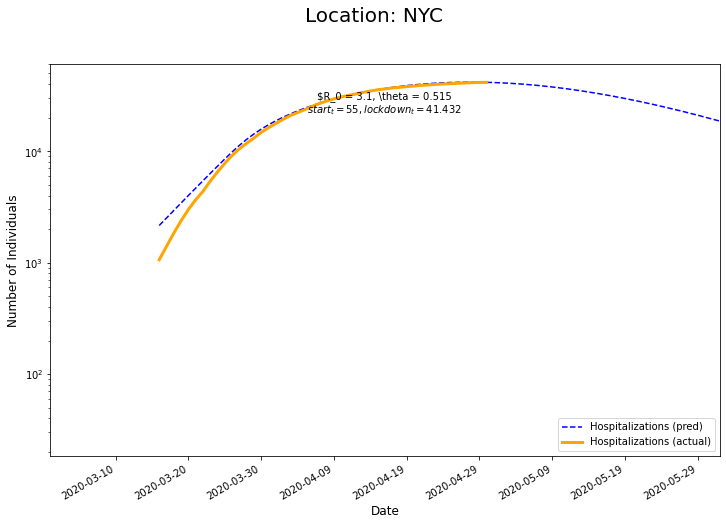

In [74]:
plot_model_fits(fitting_results_hosp_nyc, "NYC", fit_hospital=True)

Here, the parameter estimates are perhaps more sensible.

### Parameterizing $\beta_{hosp}$

Under the healthcare model, we allow infected hospital patients to infect susceptible healthcare workers. We parameterize the interaction term of this additional route of infections as $\beta_{hosp}=c f \beta_{T}$ where $c$ is a parameter. We choose the value of $c$ based on $\kappa$, the resulting relative risk of a nEW infecting a healthcare worker vs infecting another nEW. The code below calculated the relationship between $\kappa$, the relative risk to healthcare workers, and the coefficient $c$ of $\beta_{hosp}$. 

[5.46254625]
2.8304


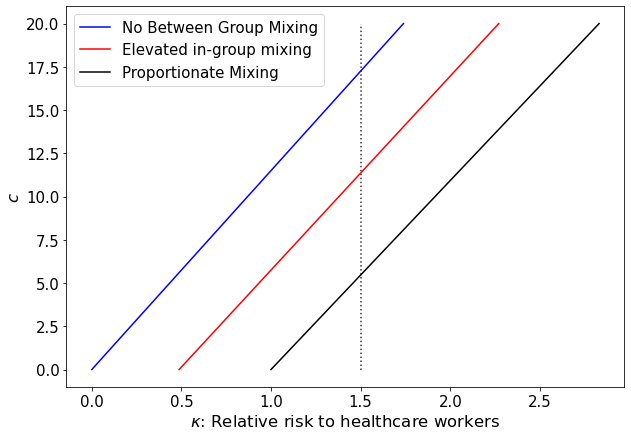

In [52]:
fig = plt.figure(figsize=(10,7))

labels = ['Proportionate Mixing','Elevated in-group mixing','No Between Group Mixing']
colors = ['black','r','blue']
update_font_size(15)

prop_essential = 0.05
x_values = np.linspace(0,20,10000)

p = args_default
avg_time_infectious = (p.p_IA * p.t_AR + (1 - p.p_IA) * ((1-p.p_IH) * p.t_IR + p.p_IH * p.t_IH))
avg_time_critical = (1 - p.p_CD) * (p.t_CL + p.t_LR) + p.p_CD * (p.t_CD)
avg_time_hospital = (1 - p.p_HC) * p.t_HR + p.p_HC * (p.t_HC + avg_time_critical)
avg_time_hospital =  (1 - p.p_IA) * p.p_IH * avg_time_hospital
        
for rho in [1,0.5,0]:
    
    G = ((1 - rho) + x_values * avg_time_hospital/(avg_time_infectious))*(1-prop_essential)
    H = 1 - (1 - rho) * prop_essential
    plt.plot(G/H,x_values,label=labels.pop(),color=colors.pop())
    plt.ylabel(r'$c$')
    plt.xlabel('$\kappa$: Relative risk to healthcare workers')
    plt.legend()

print(x_values[np.where(np.abs(G/H-1.5) == min(np.abs(G/H-1.5)))])
print(max(G/H))
plt.vlines([1.5],ymin = 0, ymax = max(x_values),color=[0.2]*3+[1],ls=':')


The above figure shows that the coefficient $c$ increases linearly with $\kappa$ under different values of $\rho$. This is because higher rates of infection between patients and healthcare workers cause a greater rate of infection in hospital workers compared to nEWs

Including this additional route of infections also increase $R_0$ while decreasing the doubling time. However, for the parameters we consider, the figure below demonstrates that this effect is small.

Text(0, 0.5, 'Doubling Time')

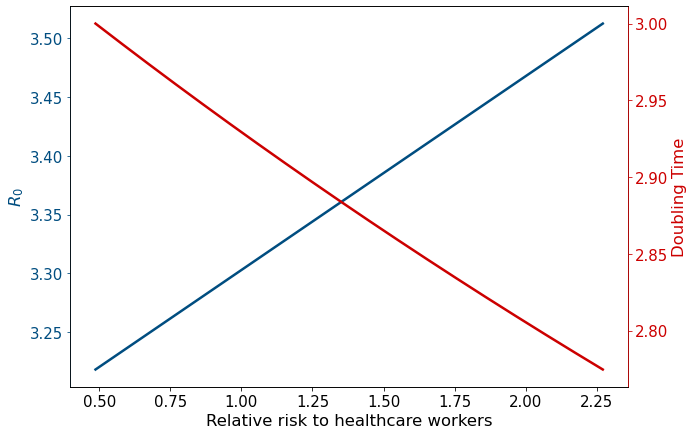

In [53]:
prop_essential = 0.05
R_0 = R0_from_doubling_time(args_default,3)

# get new R_0  including within hospital infections
r0 = R_0 + avg_time_hospital * x_values * R_0/avg_time_infectious * prop_essential

# get kappa from beta_hosp coefficients
rho = 0.5
G = ((1 - rho) + x_values * avg_time_hospital/(avg_time_infectious))*(1-prop_essential)
H = 1 - (1 - rho) * prop_essential
GH = G/H

update_font_size(15)

# plot increased R0
fig = plt.figure(figsize=(10,7))
ax_color = [0,0.3,0.5,1]
plt.plot(G/H,r0,linewidth=2.5,color=ax_color)
plt.ylabel(r'$R_0$',color = ax_color)
plt.xlabel('Relative risk to healthcare workers')
ax = plt.gca()
ax.spines['left'].set_color(ax_color)
ax.tick_params(axis='y', colors=ax_color)

#plot decreased doubling time
ax1 = ax.twinx()
plt.sca(ax1)
ax1_color = [0.8,0,0,1]
d = (args_default.t_inc + avg_time_infectious + avg_time_hospital * prop_essential * x_values) * np.log(2) / (r0 - 1)
plt.plot(G/H,d,linewidth = 2.5,color=ax1_color) 
ax1.spines['right'].set_color(ax1_color)
ax1.tick_params(axis='y', colors=ax1_color)
ax1.set_ylabel('Doubling Time',color=ax1_color)

As the risk to healthcare workers increases from 0 to 2.25, the changes to $R_0$ and the doubling time are only about 10% of their original values. The code below calculates the effects of changing $\kappa$ on different model outcomes.

In [54]:

def vary_kappa_hosp(theta_values, healthcare_model,t_measure = 100,
                    models = ['No Structure'], 
                    max_days = 500, R_0=3.2, I0=10, 
                    f = 0.05, rho = 0, 
                    model_dependent_f = {'No Structure': 0.05}, model_dependent_rho = {'No Structure': 0},
                    t_lockdown = 50, adjust_beta_hosp = [1]):
    
    results = lambda s: (sum(s[1,1:,100]),
                         sum(s[1,1:,-1]),
                         sum(s[0,1:,-1]))
    
    solution_results_all = {}
    comparison_results_all = {}
    
    for theta in theta_values:
        solution_results = {}
        for index,gamma in enumerate(adjust_beta_hosp):

            solution,p = run_model(theta = theta,
                                     R_0 = R_0,
                                     t_lockdown = t_lockdown,
                                     model = healthcare_model,
                                     n_infected = I0,
                                     n_exposed  = 0,
                                     prop_essential = f,
                                     max_days = max_days,
                                     rho = rho,
                                     adjust_beta_hosp = gamma*f,
                                     doubling_time = 3)

            solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])
            
            
            avg_solution = (solution_matrix[0,:,:]+solution_matrix[1,:,:])/8e6

            solution_matrix[0,:,:] = solution_matrix[0,:,:]/(8e6*(1-f))
            solution_matrix[1,:,:] = solution_matrix[1,:,:]/(8e6*f)
            R_effective, Betas, gg = get_R_effective(solution_matrix,p)
#             print(gamma,get_infectious_beta(p),sum(Betas[:,0,0]),Betas[:,:,0])

            solution_results[gamma] = results(solution_matrix)

        comparison_results = {}
        for index,model in enumerate(models):

            f1 = model_dependent_f[model]
            rho1 = model_dependent_rho[model]

            solution,p = run_model(theta = theta,
                                     R_0 = R_0,
                                     t_lockdown = t_lockdown,
                                     model = model,
                                     n_infected = I0,
                                     n_exposed  = 0,
                                     prop_essential = f1,
                                     max_days = max_days,
                                     rho = rho1,
                                     adjust_beta_hosp = 0,
                                     doubling_time = 3)

            solution_matrix = np.reshape(solution.y,[p.num_groups,len(p.compartment_names),p.max_days])

            avg_solution = (solution_matrix[0,:,:]+solution_matrix[1,:,:])/8e6
            solution_matrix[0,:,:] = solution_matrix[0,:,:]/(8e6*(1-f))
            solution_matrix[1,:,:] = solution_matrix[1,:,:]/(8e6*f)

            comparison_results[model] = results(solution_matrix)
    
        comparison_results_all[theta] = comparison_results
        solution_results_all[theta]   = solution_results
        
    return solution_results_all,comparison_results_all

# Assign row and column labels for the plots of the effective R over time
def assign_row_label_varyKappa(ax,text,pad = 5, xy = (0,0.5)):
    
    ax.annotate(text+'\n', xy=xy, xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='center', va='center',rotation=90)
    
# Label is the value of R_effective
def assign_column_label_varyKappa(ax,index, pad = 5, xy = (0.5,1)):
    if index == 0:
        label = 'Prevalence in EWs after 100 days'
    elif index == 1:
        label = 'Prevalence in EWs after max days'
    elif index == 2:
        label = 'Prevalence in nEWs after max days'
    pad = 5 # in points
    ax.annotate(label+'\n', xy=xy, xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
def plot_vary_kappa(solution_results_all,comparison_results_all,linewidth = 4, font_size = 30,figsize = (40,40)):
    
    ls_styles = {'No Structure':('-',[0,0,0,0.5]),
             'Cashier':(':',[0,0,1,1]),
             'Healthcare':('--','r'),
             'USPS':('-.','g'),
             'Healthcare_Sigmoid':('-.','purple')}
        
    G = lambda x_values: ((1 - rho) + x_values * avg_time_hospital/(avg_time_infectious))*(1-prop_essential)
    H = 1 - (1 - rho) * prop_essential
    kappa = lambda x_values: G(x_values)/H
    
    update_font_size(font_size,rcParams = mpl.rcParams)
    fig, axes_all = plt.subplots(ncols = 3,nrows = len(solution_results_all.keys()),figsize=(50,10*len(solution_results_all.keys())))
    
    for i,((theta,solution_results),(theta,comparison_results)) in enumerate(zip(solution_results_all.items(),comparison_results_all.items())):
        
        for j,ax in enumerate(axes_all[i]):
            x_values = np.sort(list(solution_results.keys()))
            y_values = np.array([solution_results[key][j] for key in x_values])
            ax.plot(kappa(x_values),y_values,linewidth = linewidth,color='r')
            

            for model,model_values in comparison_results.items():
                ls,color = ls_styles[model]
                ax.hlines(model_values[j],xmin = min(kappa(x_values)),xmax = max(kappa(x_values)),color= color,label=model,linewidth = linewidth)
                if model == 'No Structure':
                    bar_height = model_values[j]*0.9
            
            if i == 0:
                assign_column_label_varyKappa(ax=ax,index = j)
            if j == 0:
                assign_row_label_varyKappa(ax=ax,text=r'$R_0 \theta = $' + '{}'.format(theta*R_0))
            
            plt.sca(ax)
            plt.xlabel(r'$\kappa$')
            plt.ylabel('Proportion Infected')

            plt.vlines(kappa(5.46254625),
                       ymin=bar_height,
                       ymax=max(max(y_values),max(list([jj[j] for jj in comparison_results.values()]))),
                       color = 'k',
                       ls = ':',
                       linewidth = linewidth)
    
    fig.tight_layout()
    # Tight_layout doesn't take these labels into account. We'll need 
    # to make some room. These numbers are are manually tweaked. 
    # You could automatically calculate them, but it's a pain.
    fig.subplots_adjust(left=0.15, top=0.85)
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [55]:
R_0 = R0_from_doubling_time(args_default,3)
keep_R0_constant = False
global_method='Radau'

desired_Reff = np.array([0.5,0.7,0.9])
s_dict,c_dict = vary_kappa_hosp(theta_values = desired_Reff/R_0 ,
                                adjust_beta_hosp = np.linspace(0,20,20), 
                                healthcare_model = 'Healthcare',
                                max_days = 300,R_0=R_0,I0=20,
                                t_lockdown = 59,
                                rho = 0.5,
                                models = ['No Structure','Cashier','USPS'],
                                
                                model_dependent_f = {'No Structure':       0.05,
                                                     'Cashier':            0.05,
                                                     'USPS':               0.05,
                                                     'Healthcare':         0.05,
                                                     'Healthcare_Sigmoid': 0.05},
                 
                                model_dependent_rho = {'No Structure': 0,
                                                        'Cashier': 0,
                                                        'Healthcare': 0,
                                                        'USPS': 0.5,
                                                        'Healthcare_Sigmoid':  0})

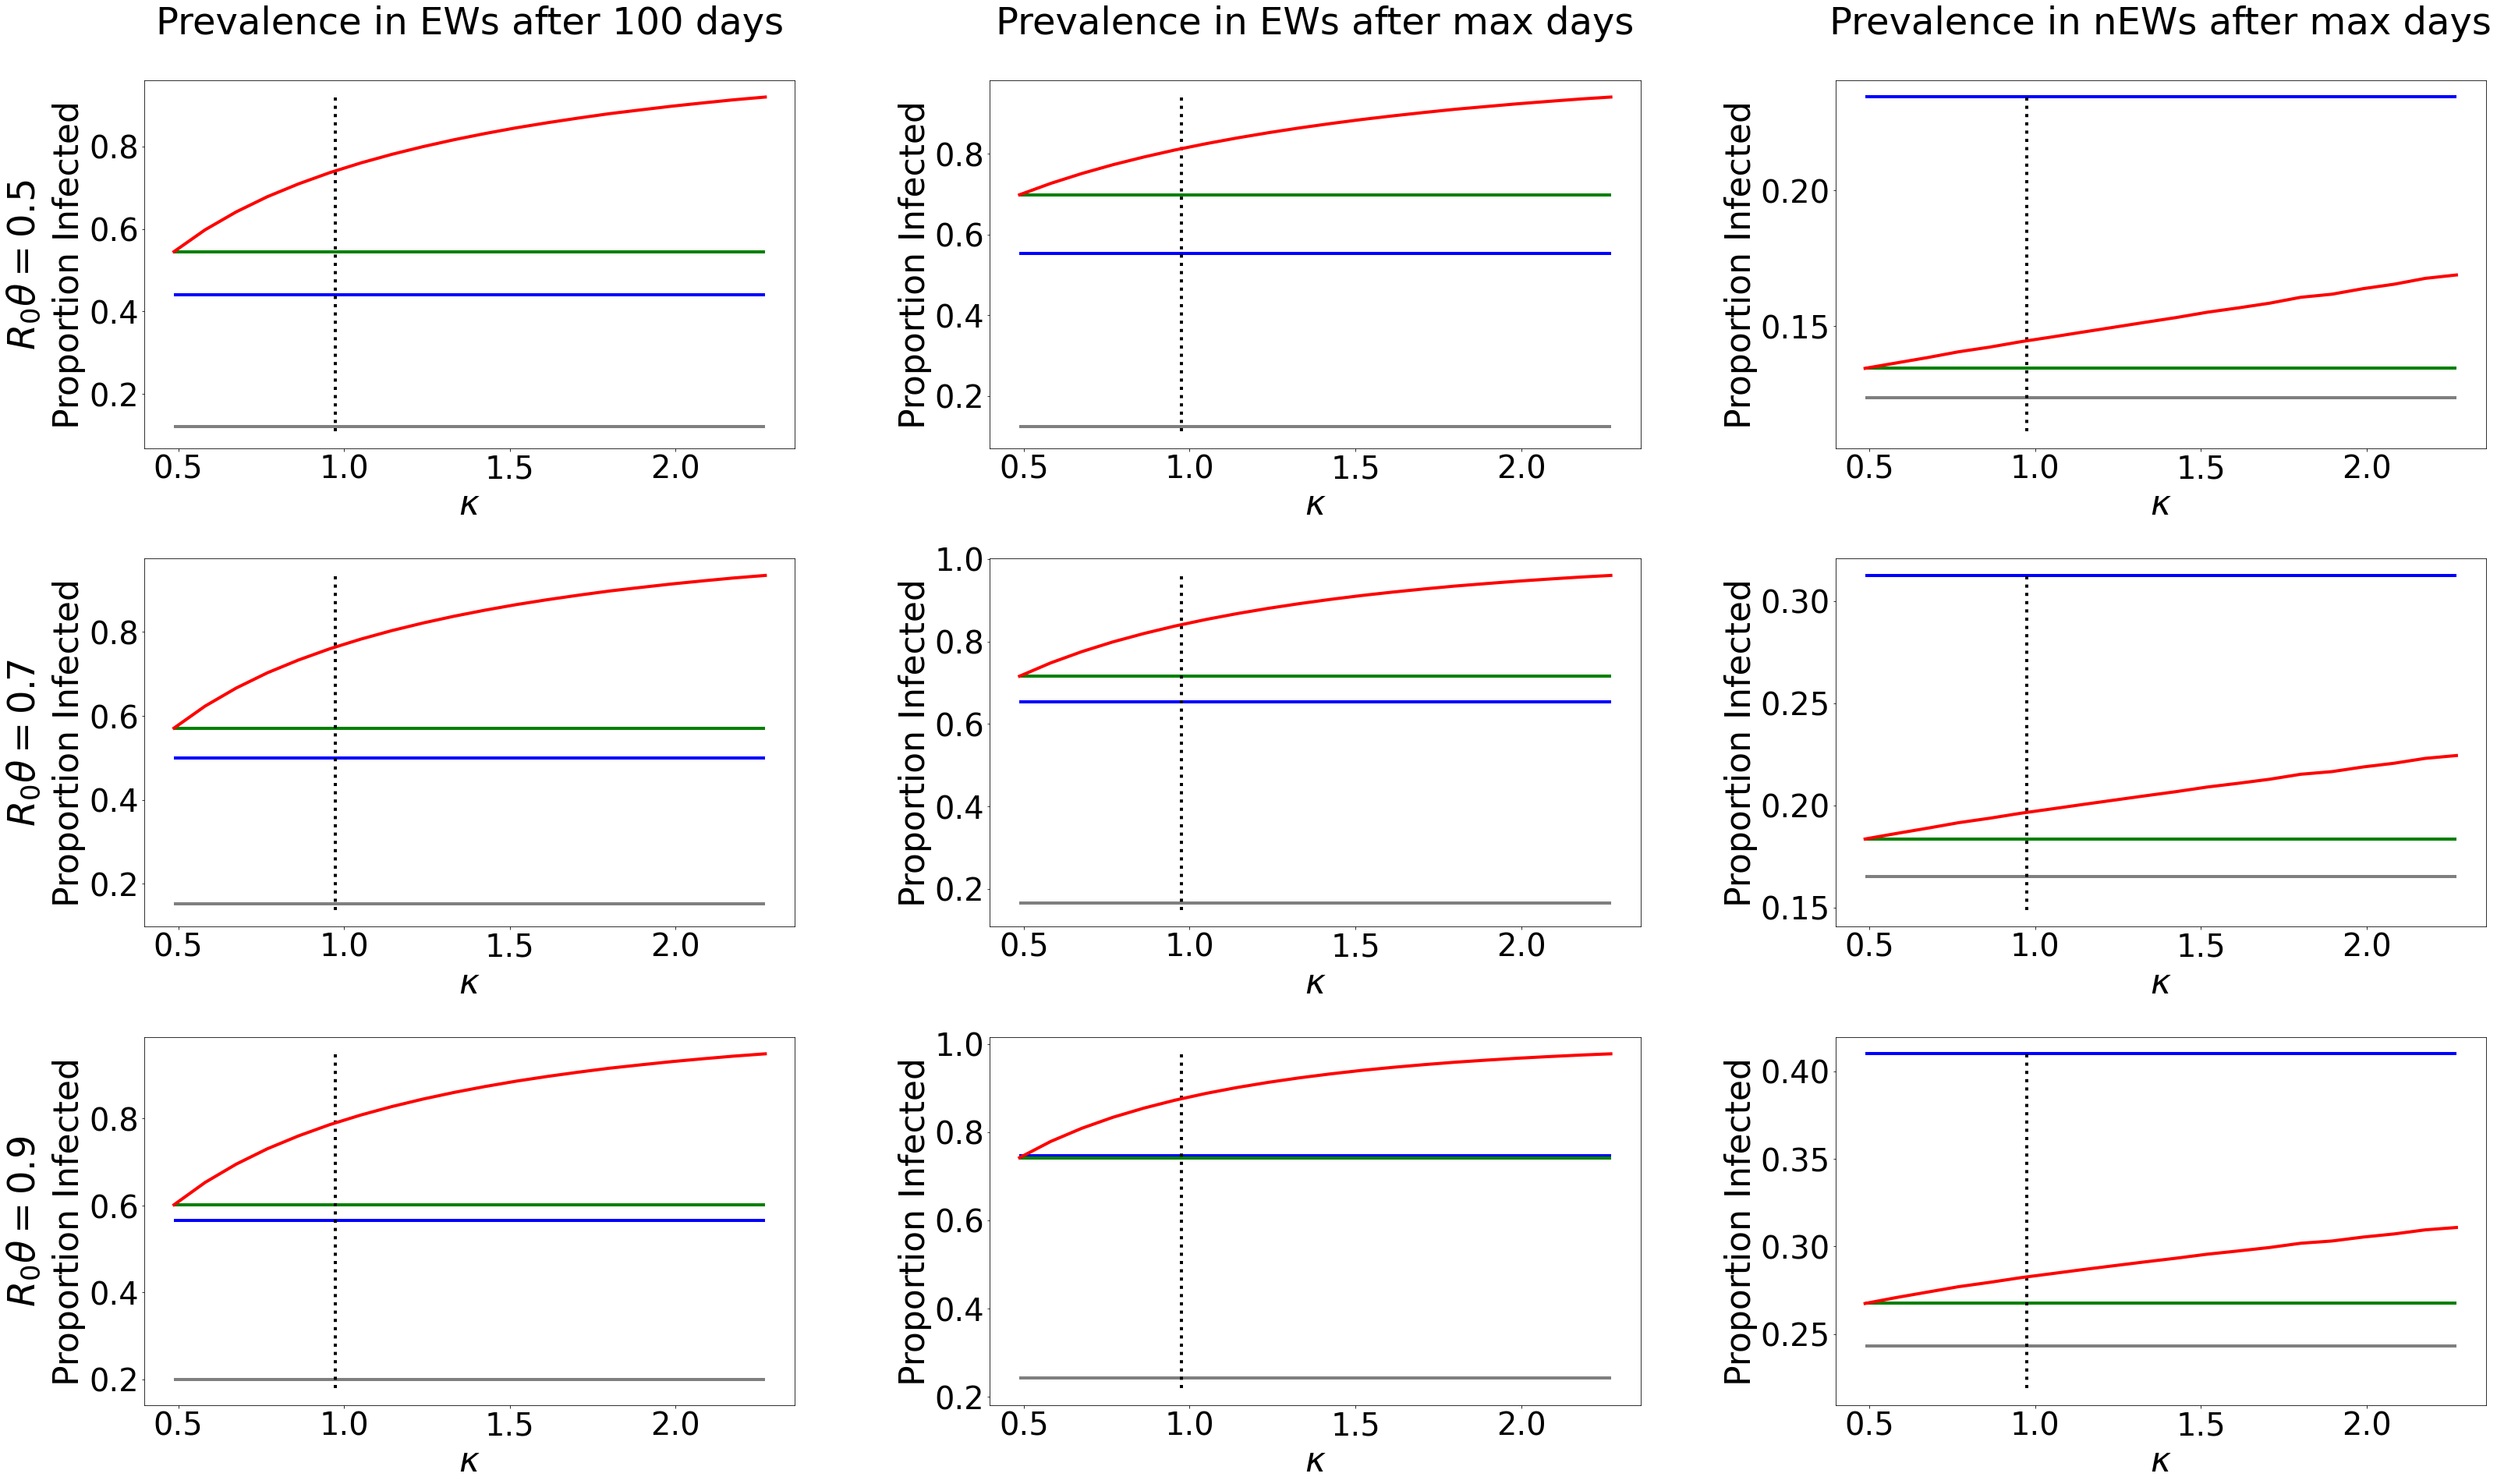

In [56]:
plot_vary_kappa(solution_results_all=s_dict,comparison_results_all=c_dict,font_size=40)

As $\kappa$ increases, so does the prevalence in healthcare workers and among nEWs. When $\kappa=1$, the model reduces to the non-public facing worker model.